# Classification on Botnet DGA Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane import numpy as np

from datetime import datetime
import os
import pickle
import time

import qiskit
import qiskit.providers.aer.noise as noise

from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

In [2]:
#IBMQ.save_account('412323e770fb2ee81fb9b79d3effe940d0a7f72c3be198a65f580a20b38b00a607ad8c8a9b5322116fc1aee89be55463fe87e7a43da6af415bbaa95236fca521')

## Experiment Settings

In [3]:
import random as python_random
SEED = 123
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

n_qubits = 2
# dev = qml.device("default.mixed", wires=n_qubits)


#dev = qml.device('qiskit.aer', wires=n_qubits)


# Error probabilities
#prob_1 = 0.001  # 1-qubit gate
#prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
#error_1 = noise.depolarizing_error(prob_1, 1)
#error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
#noise_model = noise.NoiseModel()
#noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
#noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Create a PennyLane device
# dev = qml.device('qiskit.aer', wires=n_qubits, noise_model=noise_model)


# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_quito')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

dev = qml.device('qiskit.aer', wires=n_qubits, backend='qasm_simulator', 
                 coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model)
#                 backend_options={"validation_threshold": 1e-6})


n_layers = 1 #6
num_data = 1000  #1803333
EPOCHS = 10000
BATCH_SIZE = 50 #2048


weight_shapes = {"weights": (n_layers, n_qubits)}

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

now = datetime.now()
results_folder = "RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-04-03/"
#"RESULTS5-QiskitNoisy/nd" + str(num_data) + "_" + "nq" + str(n_qubits) + "_" + "nl" + str(n_layers) + "_" + now.strftime("%m-%d-%Y_%H-%M-%S") + "/"
print("results_folder: ",results_folder)
#os.mkdir(results_folder)

f = open(results_folder + "results.txt", "a", encoding='utf-8')
f.write(results_folder + "\n")

mpl.rcParams['savefig.dpi'] = 600

results_folder:  RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-04-03/


## Example of a QNode

In [4]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

## Data processing and exploration

### Load csv data set

In [5]:
#raw_df = pd.read_csv("dataset/n"+str(num_data)+"_botnetdga_TRAIN.csv")
#raw_df.head()

In [6]:
#raw_df[['Entropy','REAlexa','MinREBotnets','InformationRadius','CharLength','TreeNewFeature','nGramReputation_Alexa','Class']].describe()

### Clean, split and normalize the data

In [7]:
#cleaned_df = raw_df.copy()
#cleaned_df.pop('Entropy')
#cleaned_df.pop('REAlexa')
#cleaned_df.pop('InformationRadius')

In [8]:
#train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
#train_df, val_df = train_test_split(train_df, test_size=0.2)

In [9]:
#train_labels = np.array(train_df.pop('Class'))
#val_labels = np.array(val_df.pop('Class'))
#test_labels = np.array(test_df.pop('Class'))

In [10]:
#train_features = np.array(train_df)
#val_features = np.array(val_df)
#test_features = np.array(test_df)

In [11]:
#scaler = StandardScaler()
#train_features = scaler.fit_transform(train_features)
#val_features = scaler.transform(val_features)
#test_features = scaler.transform(test_features)

In [12]:
#train_features = np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)

## Loads the already prepared benchmark datasets

In [13]:
test_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_features.csv") )
test_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_labels.csv") )

train_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_features.csv") )
train_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_labels.csv") )

val_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_features.csv") )
val_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_labels.csv") )

## Define the model and metrics 

In [14]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          n_qubits, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      qlayer,
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)

In [16]:
def plot_loss(history, label, n, expId):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(results_folder + '_' + str(expId) + '_plot_loss.png', format='png')

    
def plot_metrics(history, expId):
  metrics = ['accuracy', 'loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(5,1,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.savefig(results_folder + '_' + str(expId) + '_plot_metrics.png', format='png')
    
def plot_cm(labels, predictions, expId , p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.savefig(results_folder + '_' + str(expId) + '_plot_cm.png', format='png')

  print('Legitimate Domain Name Detected (True Negatives): ', cm[0][0])
  print('Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives): ', cm[0][1])
  print('Botnet DGA Missed (False Negatives): ', cm[1][0])
  print('Botnet DGA Detected (True Positives): ', cm[1][1])
  print('Total Botnet DGAs: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [17]:
model = make_model()

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

print("initial_weights = ", initial_weights)

initial_weights =  /tmp/tmp56256btn/initial_weights


# Experiments A - Hybrid Classical-Quantum DL

In [18]:
def runTheExperiments(expId, desc, model=None):
    
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(SEED)
    python_random.seed(SEED)
    tf.random.set_seed(SEED)

    start_time = time.time()
    f.write("\n\n\n#" + desc + "\n")
    
    if model is None:
        model = make_model()
        model.load_weights(initial_weights)

    history = model.fit(
        train_features,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=(val_features, val_labels))

    #model.save(results_folder + 'model_' + str(expId))
    #with open(results_folder + 'history_' + str(expId), 'wb') as file_pi:
    #    pickle.dump(history.history, file_pi)

    train_predictions = model.predict(train_features, batch_size=BATCH_SIZE)
    test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)


    plot_loss(history, "history", 0, expId=expId)

    plot_metrics(history, expId=expId)

    baseline_results = model.evaluate(test_features, test_labels,
                                      batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
      print(name, ': ', value)
      f.write(name + ' : \t' + str(value) + "\n")
    print()
    plot_cm(test_labels, test_predictions, expId=expId)

    plot_roc("Train", train_labels, train_predictions, color=colors[0])
    plot_roc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')
    plt.legend(loc='lower right')
    plt.savefig(results_folder + '_' + str(expId) + '_plot_roc.png', format='png')
    
    f.write("--- %s seconds ---" % (time.time() - start_time))  
    f.write("\n\n")
    f.write(qnode.draw())
    f.flush()
    
    tf.keras.utils.plot_model(
    model, to_file=results_folder+'model'+ str(expId) + '.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=600
    )
        
    return model, history
    

## AngleEmbedding

Epoch 1/10000
13/13 [==============================] - 425s 33s/step - loss: 0.7140 - tp: 85.8571 - fp: 97.4286 - tn: 93.0714 - fn: 93.5000 - accuracy: 0.4860 - precision: 0.4659 - recall: 0.4814 - auc: 0.4854 - val_loss: 0.7616 - val_tp: 19.0000 - val_fp: 30.0000 - val_tn: 43.0000 - val_fn: 67.0000 - val_accuracy: 0.3899 - val_precision: 0.3878 - val_recall: 0.2209 - val_auc: 0.2679
Epoch 2/10000
13/13 [==============================] - 447s 34s/step - loss: 0.7233 - tp: 73.9286 - fp: 74.0000 - tn: 117.9286 - fn: 104.0000 - accuracy: 0.5086 - precision: 0.4795 - recall: 0.4143 - auc: 0.4686 - val_loss: 0.7551 - val_tp: 17.0000 - val_fp: 30.0000 - val_tn: 43.0000 - val_fn: 69.0000 - val_accuracy: 0.3774 - val_precision: 0.3617 - val_recall: 0.1977 - val_auc: 0.2638
Epoch 3/10000
13/13 [==============================] - 447s 34s/step - loss: 0.7303 - tp: 55.7143 - fp: 55.9286 - tn: 137.8571 - fn: 120.3571 - accuracy: 0.5292 - precision: 0.4888 - recall: 0.3197 - auc: 0.4279 - val_loss: 

13/13 [==============================] - 451s 35s/step - loss: 0.6276 - tp: 59.7857 - fp: 5.9286 - tn: 185.8571 - fn: 118.2857 - accuracy: 0.6543 - precision: 0.9244 - recall: 0.3047 - auc: 0.7256 - val_loss: 0.6254 - val_tp: 49.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 37.0000 - val_accuracy: 0.7421 - val_precision: 0.9245 - val_recall: 0.5698 - val_auc: 0.8420
Epoch 44/10000
13/13 [==============================] - 451s 35s/step - loss: 0.6016 - tp: 69.5714 - fp: 9.7857 - tn: 183.5000 - fn: 107.0000 - accuracy: 0.6918 - precision: 0.8611 - recall: 0.4076 - auc: 0.7555 - val_loss: 0.6260 - val_tp: 47.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 39.0000 - val_accuracy: 0.7358 - val_precision: 0.9400 - val_recall: 0.5465 - val_auc: 0.8350
Epoch 45/10000
13/13 [==============================] - 451s 35s/step - loss: 0.6265 - tp: 73.0714 - fp: 10.3571 - tn: 180.9286 - fn: 105.5000 - accuracy: 0.6796 - precision: 0.8711 - recall: 0.3986 - auc: 0.7083 - val_loss: 0.6264 - val_t

13/13 [==============================] - 453s 35s/step - loss: 0.5784 - tp: 79.7857 - fp: 9.0000 - tn: 184.6429 - fn: 96.4286 - accuracy: 0.7142 - precision: 0.9031 - recall: 0.4397 - auc: 0.7349 - val_loss: 0.5776 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.8417
Epoch 86/10000
13/13 [==============================] - 453s 35s/step - loss: 0.5694 - tp: 87.6429 - fp: 9.8571 - tn: 176.0714 - fn: 96.2857 - accuracy: 0.7075 - precision: 0.8953 - recall: 0.4747 - auc: 0.7668 - val_loss: 0.5763 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 27.0000 - val_accuracy: 0.7987 - val_precision: 0.9219 - val_recall: 0.6860 - val_auc: 0.8588
Epoch 87/10000
13/13 [==============================] - 452s 35s/step - loss: 0.5884 - tp: 78.2143 - fp: 10.7857 - tn: 178.8571 - fn: 102.0000 - accuracy: 0.6972 - precision: 0.8704 - recall: 0.4499 - auc: 0.7183 - val_loss: 0.5756 - val_tp:

13/13 [==============================] - 452s 35s/step - loss: 0.5629 - tp: 91.0000 - fp: 11.3571 - tn: 175.3571 - fn: 92.1429 - accuracy: 0.7261 - precision: 0.8984 - recall: 0.5161 - auc: 0.7773 - val_loss: 0.5502 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.8724
Epoch 128/10000
13/13 [==============================] - 453s 35s/step - loss: 0.5665 - tp: 89.1429 - fp: 11.6429 - tn: 178.6429 - fn: 90.4286 - accuracy: 0.7200 - precision: 0.8851 - recall: 0.4958 - auc: 0.7738 - val_loss: 0.5491 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.8707
Epoch 129/10000
13/13 [==============================] - 452s 35s/step - loss: 0.5666 - tp: 89.9286 - fp: 9.4286 - tn: 175.0714 - fn: 95.4286 - accuracy: 0.7157 - precision: 0.9193 - recall: 0.4904 - auc: 0.7648 - val_loss: 0.5477 - val_t

13/13 [==============================] - 452s 35s/step - loss: 0.5496 - tp: 93.1429 - fp: 8.6429 - tn: 182.3571 - fn: 85.7143 - accuracy: 0.7396 - precision: 0.9292 - recall: 0.5086 - auc: 0.7703 - val_loss: 0.5348 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.8868
Epoch 170/10000
13/13 [==============================] - 454s 35s/step - loss: 0.5398 - tp: 96.0714 - fp: 11.6429 - tn: 182.7143 - fn: 79.4286 - accuracy: 0.7491 - precision: 0.8713 - recall: 0.5429 - auc: 0.7940 - val_loss: 0.5351 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.8796
Epoch 171/10000
13/13 [==============================] - 452s 35s/step - loss: 0.5169 - tp: 93.7143 - fp: 8.0714 - tn: 186.4286 - fn: 81.6429 - accuracy: 0.7684 - precision: 0.9227 - recall: 0.5561 - auc: 0.7743 - val_loss: 0.5353 - val_tp

13/13 [==============================] - 455s 35s/step - loss: 0.5136 - tp: 101.0714 - fp: 4.1429 - tn: 187.0000 - fn: 77.6429 - accuracy: 0.7710 - precision: 0.9634 - recall: 0.5466 - auc: 0.7898 - val_loss: 0.5204 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9088
Epoch 212/10000
13/13 [==============================] - 454s 35s/step - loss: 0.5384 - tp: 94.0000 - fp: 12.6429 - tn: 180.7857 - fn: 82.4286 - accuracy: 0.7494 - precision: 0.8926 - recall: 0.5430 - auc: 0.7541 - val_loss: 0.5211 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9121
Epoch 213/10000
13/13 [==============================] - 452s 35s/step - loss: 0.5269 - tp: 105.4286 - fp: 10.9286 - tn: 180.3571 - fn: 73.1429 - accuracy: 0.7680 - precision: 0.8997 - recall: 0.5787 - auc: 0.7666 - val_loss: 0.5233 - val

13/13 [==============================] - 453s 35s/step - loss: 0.5017 - tp: 102.8571 - fp: 7.6429 - tn: 186.1429 - fn: 73.2143 - accuracy: 0.7830 - precision: 0.9245 - recall: 0.5857 - auc: 0.7731 - val_loss: 0.5151 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9272
Epoch 254/10000
13/13 [==============================] - 453s 35s/step - loss: 0.4802 - tp: 112.3571 - fp: 7.0714 - tn: 182.8571 - fn: 67.5714 - accuracy: 0.8022 - precision: 0.9378 - recall: 0.6281 - auc: 0.8299 - val_loss: 0.5136 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9275
Epoch 255/10000
13/13 [==============================] - 454s 35s/step - loss: 0.4781 - tp: 110.0714 - fp: 7.7857 - tn: 181.7857 - fn: 70.2143 - accuracy: 0.7922 - precision: 0.9366 - recall: 0.6127 - auc: 0.8111 - val_loss: 0.5140 - val_

13/13 [==============================] - 453s 35s/step - loss: 0.4885 - tp: 108.7857 - fp: 11.0714 - tn: 178.0714 - fn: 71.9286 - accuracy: 0.7756 - precision: 0.8950 - recall: 0.6101 - auc: 0.8039 - val_loss: 0.5018 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9449
Epoch 296/10000
13/13 [==============================] - 453s 35s/step - loss: 0.4956 - tp: 112.0000 - fp: 9.5000 - tn: 181.7857 - fn: 66.5714 - accuracy: 0.7901 - precision: 0.9150 - recall: 0.6262 - auc: 0.7833 - val_loss: 0.5039 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9410
Epoch 297/10000
13/13 [==============================] - 454s 35s/step - loss: 0.4798 - tp: 106.1429 - fp: 6.8571 - tn: 185.7143 - fn: 71.1429 - accuracy: 0.7883 - precision: 0.9444 - recall: 0.5965 - auc: 0.8018 - val_loss: 0.5022 - val

13/13 [==============================] - 433s 33s/step - loss: 0.5109 - tp: 96.5714 - fp: 7.2143 - tn: 192.7143 - fn: 73.3571 - accuracy: 0.7762 - precision: 0.9182 - recall: 0.5538 - auc: 0.7471 - val_loss: 0.5010 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9368
Epoch 338/10000
13/13 [==============================] - 433s 33s/step - loss: 0.5054 - tp: 97.0714 - fp: 6.9286 - tn: 189.5000 - fn: 76.3571 - accuracy: 0.7801 - precision: 0.9411 - recall: 0.5568 - auc: 0.7606 - val_loss: 0.4999 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9392
Epoch 339/10000
13/13 [==============================] - 432s 33s/step - loss: 0.4945 - tp: 112.9286 - fp: 7.1429 - tn: 181.5000 - fn: 68.2857 - accuracy: 0.7862 - precision: 0.9477 - recall: 0.6107 - auc: 0.7697 - val_loss: 0.4967 - val_tp

13/13 [==============================] - 433s 33s/step - loss: 0.4817 - tp: 109.2857 - fp: 4.9286 - tn: 187.2143 - fn: 68.4286 - accuracy: 0.8027 - precision: 0.9599 - recall: 0.6198 - auc: 0.7887 - val_loss: 0.4917 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9435
Epoch 380/10000
13/13 [==============================] - 434s 33s/step - loss: 0.5062 - tp: 99.7143 - fp: 7.7857 - tn: 186.7857 - fn: 75.5714 - accuracy: 0.7732 - precision: 0.9193 - recall: 0.5673 - auc: 0.7902 - val_loss: 0.4899 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9440
Epoch 381/10000
13/13 [==============================] - 434s 33s/step - loss: 0.4589 - tp: 110.4286 - fp: 5.8571 - tn: 188.2857 - fn: 65.2857 - accuracy: 0.8093 - precision: 0.9491 - recall: 0.6358 - auc: 0.8209 - val_loss: 0.4936 - val_t

13/13 [==============================] - 435s 33s/step - loss: 0.4687 - tp: 106.7143 - fp: 5.0714 - tn: 189.7857 - fn: 68.2857 - accuracy: 0.8083 - precision: 0.9579 - recall: 0.6154 - auc: 0.7833 - val_loss: 0.4870 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9457
Epoch 422/10000
13/13 [==============================] - 435s 33s/step - loss: 0.4870 - tp: 110.2857 - fp: 8.5714 - tn: 183.4286 - fn: 67.5714 - accuracy: 0.7866 - precision: 0.9065 - recall: 0.6103 - auc: 0.7943 - val_loss: 0.4878 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9486
Epoch 423/10000
13/13 [==============================] - 433s 33s/step - loss: 0.5314 - tp: 100.3571 - fp: 6.7857 - tn: 176.8571 - fn: 85.8571 - accuracy: 0.7350 - precision: 0.9304 - recall: 0.5305 - auc: 0.7684 - val_loss: 0.4802 - val_

13/13 [==============================] - 433s 33s/step - loss: 0.4833 - tp: 99.0714 - fp: 4.0000 - tn: 188.2857 - fn: 78.5000 - accuracy: 0.7825 - precision: 0.9663 - recall: 0.5674 - auc: 0.7649 - val_loss: 0.4750 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9427
Epoch 464/10000
13/13 [==============================] - 433s 33s/step - loss: 0.4820 - tp: 108.1429 - fp: 8.2857 - tn: 180.2857 - fn: 73.1429 - accuracy: 0.7831 - precision: 0.9292 - recall: 0.6041 - auc: 0.7941 - val_loss: 0.4737 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9532
Epoch 465/10000
13/13 [==============================] - 433s 33s/step - loss: 0.4427 - tp: 115.5000 - fp: 7.4286 - tn: 186.1429 - fn: 60.7857 - accuracy: 0.8199 - precision: 0.9381 - recall: 0.6594 - auc: 0.8184 - val_loss: 0.4809 - val_t

13/13 [==============================] - 434s 33s/step - loss: 0.4942 - tp: 110.0714 - fp: 4.7857 - tn: 178.8571 - fn: 76.1429 - accuracy: 0.7676 - precision: 0.9539 - recall: 0.5838 - auc: 0.7881 - val_loss: 0.4784 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9415
Epoch 506/10000
13/13 [==============================] - 432s 33s/step - loss: 0.4709 - tp: 112.4286 - fp: 5.7857 - tn: 184.5000 - fn: 67.1429 - accuracy: 0.7998 - precision: 0.9458 - recall: 0.6110 - auc: 0.7823 - val_loss: 0.4765 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9466
Epoch 507/10000
13/13 [==============================] - 434s 33s/step - loss: 0.4736 - tp: 109.5714 - fp: 7.3571 - tn: 186.1429 - fn: 66.7857 - accuracy: 0.7966 - precision: 0.9337 - recall: 0.6072 - auc: 0.7957 - val_loss: 0.4760 - val_

13/13 [==============================] - 433s 33s/step - loss: 0.4609 - tp: 118.7857 - fp: 9.2143 - tn: 181.2857 - fn: 60.5714 - accuracy: 0.8090 - precision: 0.9284 - recall: 0.6626 - auc: 0.8209 - val_loss: 0.4707 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9450
Epoch 548/10000
13/13 [==============================] - 434s 33s/step - loss: 0.4454 - tp: 111.9286 - fp: 5.9286 - tn: 188.3571 - fn: 63.6429 - accuracy: 0.8235 - precision: 0.9527 - recall: 0.6586 - auc: 0.8341 - val_loss: 0.4692 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9504
Epoch 549/10000
13/13 [==============================] - 433s 33s/step - loss: 0.4913 - tp: 106.6429 - fp: 7.3571 - tn: 180.4286 - fn: 75.4286 - accuracy: 0.7679 - precision: 0.9338 - recall: 0.5644 - auc: 0.7600 - val_loss: 0.4697 - val_

13/13 [==============================] - 435s 33s/step - loss: 0.4595 - tp: 113.3571 - fp: 5.2143 - tn: 189.5714 - fn: 61.7143 - accuracy: 0.8189 - precision: 0.9625 - recall: 0.6295 - auc: 0.8101 - val_loss: 0.4631 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9431
Epoch 590/10000
13/13 [==============================] - 433s 33s/step - loss: 0.4803 - tp: 112.9286 - fp: 8.6429 - tn: 177.7857 - fn: 70.5000 - accuracy: 0.7943 - precision: 0.9370 - recall: 0.6289 - auc: 0.7961 - val_loss: 0.4642 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9519
Epoch 591/10000
13/13 [==============================] - 434s 33s/step - loss: 0.4425 - tp: 110.8571 - fp: 4.5000 - tn: 190.0714 - fn: 64.4286 - accuracy: 0.8217 - precision: 0.9709 - recall: 0.6425 - auc: 0.7974 - val_loss: 0.4592 - val_

13/13 [==============================] - 435s 34s/step - loss: 0.4980 - tp: 105.5714 - fp: 7.0714 - tn: 185.2143 - fn: 72.0000 - accuracy: 0.7862 - precision: 0.9355 - recall: 0.5908 - auc: 0.7687 - val_loss: 0.4622 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9466
Epoch 632/10000
13/13 [==============================] - 433s 33s/step - loss: 0.4699 - tp: 105.2143 - fp: 5.2143 - tn: 188.5000 - fn: 70.9286 - accuracy: 0.7978 - precision: 0.9556 - recall: 0.5978 - auc: 0.7907 - val_loss: 0.4620 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9490
Epoch 633/10000
13/13 [==============================] - 434s 33s/step - loss: 0.4368 - tp: 119.7143 - fp: 5.0714 - tn: 185.0714 - fn: 60.0000 - accuracy: 0.8267 - precision: 0.9660 - recall: 0.6751 - auc: 0.8145 - val_loss: 0.4611 - val_

13/13 [==============================] - 434s 33s/step - loss: 0.4989 - tp: 107.3571 - fp: 5.7143 - tn: 178.5714 - fn: 78.2143 - accuracy: 0.7666 - precision: 0.9544 - recall: 0.5767 - auc: 0.7748 - val_loss: 0.4599 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9496
Epoch 674/10000
13/13 [==============================] - 433s 33s/step - loss: 0.4386 - tp: 115.3571 - fp: 7.2857 - tn: 186.7857 - fn: 60.4286 - accuracy: 0.8208 - precision: 0.9409 - recall: 0.6573 - auc: 0.8106 - val_loss: 0.4595 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9521
Epoch 675/10000
13/13 [==============================] - 434s 33s/step - loss: 0.4366 - tp: 111.1429 - fp: 7.3571 - tn: 191.6429 - fn: 59.7143 - accuracy: 0.8292 - precision: 0.9395 - recall: 0.6646 - auc: 0.8062 - val_loss: 0.4624 - val_

13/13 [==============================] - 435s 33s/step - loss: 0.4277 - tp: 117.7143 - fp: 6.2857 - tn: 184.7857 - fn: 61.0714 - accuracy: 0.8254 - precision: 0.9602 - recall: 0.6685 - auc: 0.8257 - val_loss: 0.4587 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9506
Epoch 716/10000
13/13 [==============================] - 434s 33s/step - loss: 0.4487 - tp: 115.7143 - fp: 9.5714 - tn: 180.4286 - fn: 64.1429 - accuracy: 0.8039 - precision: 0.9215 - recall: 0.6536 - auc: 0.8002 - val_loss: 0.4579 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9513
Epoch 717/10000
13/13 [==============================] - 436s 34s/step - loss: 0.4792 - tp: 104.5000 - fp: 8.8571 - tn: 186.4286 - fn: 70.0714 - accuracy: 0.7827 - precision: 0.9283 - recall: 0.5888 - auc: 0.7652 - val_loss: 0.4630 - val_

13/13 [==============================] - 434s 33s/step - loss: 0.4592 - tp: 113.1429 - fp: 5.2143 - tn: 181.4286 - fn: 70.0714 - accuracy: 0.7971 - precision: 0.9645 - recall: 0.6196 - auc: 0.8052 - val_loss: 0.4551 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9498
Epoch 758/10000
13/13 [==============================] - 434s 33s/step - loss: 0.4731 - tp: 109.5000 - fp: 6.7857 - tn: 186.0000 - fn: 67.5714 - accuracy: 0.7931 - precision: 0.9376 - recall: 0.6003 - auc: 0.7997 - val_loss: 0.4563 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9450
Epoch 759/10000
13/13 [==============================] - 436s 34s/step - loss: 0.4660 - tp: 107.9286 - fp: 5.4286 - tn: 183.4286 - fn: 73.0714 - accuracy: 0.7934 - precision: 0.9513 - recall: 0.6149 - auc: 0.7937 - val_loss: 0.4534 - val_

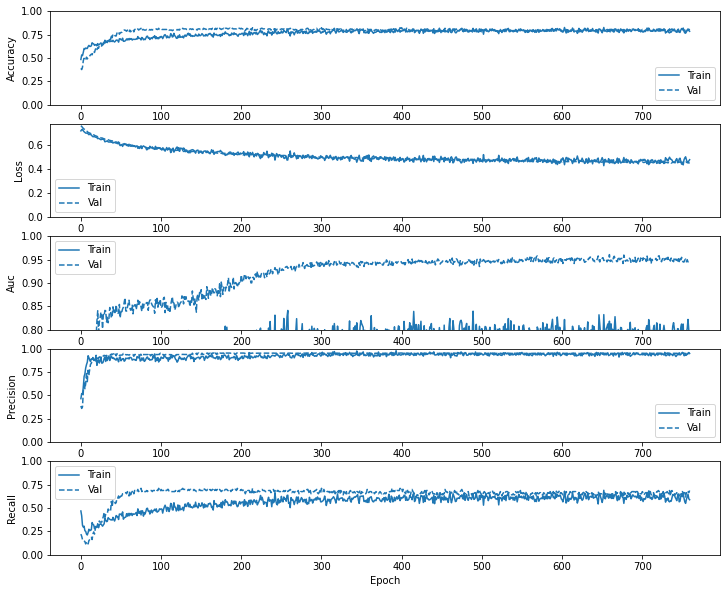

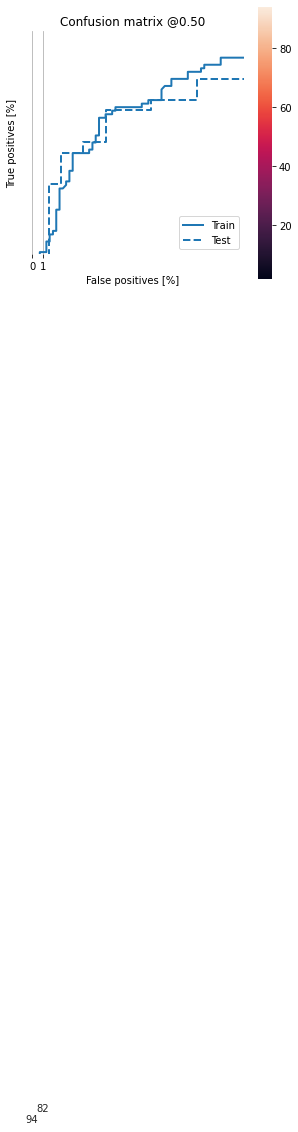

In [19]:
%%time
expId = 101
desc = str(expId) + " AngleEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits)) 
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_101, history_101 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 404s 31s/step - loss: 0.9208 - tp: 241.4286 - fp: 192.5000 - tn: 94.0000 - fn: 40.9286 - accuracy: 0.6114 - precision: 0.5831 - recall: 0.8458 - auc: 0.6843 - val_loss: 0.8136 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.6630
Epoch 2/10000
13/13 [==============================] - 404s 31s/step - loss: 0.9175 - tp: 162.7857 - fp: 191.4286 - tn: 0.5000 - fn: 15.1429 - accuracy: 0.4328 - precision: 0.4507 - recall: 0.9127 - auc: 0.4807 - val_loss: 0.8021 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.6465
Epoch 3/10000
13/13 [==============================] - 405s 31s/step - loss: 0.9220 - tp: 156.7857 - fp: 193.4286 - tn: 0.3571 - fn: 19.2857 - accuracy: 0.4152 - precision: 0.4367 - recall: 0.8939 - auc: 0.4588 

Epoch 22/10000
13/13 [==============================] - 404s 31s/step - loss: 0.6693 - tp: 170.8571 - fp: 185.8571 - tn: 1.7143 - fn: 11.4286 - accuracy: 0.4693 - precision: 0.4842 - recall: 0.9319 - auc: 0.6233 - val_loss: 0.6214 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.7969
Epoch 23/10000
13/13 [==============================] - 404s 31s/step - loss: 0.6631 - tp: 172.9286 - fp: 187.2143 - tn: 1.2143 - fn: 8.5000 - accuracy: 0.4751 - precision: 0.4849 - recall: 0.9544 - auc: 0.6021 - val_loss: 0.6160 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8128
Epoch 24/10000
13/13 [==============================] - 402s 31s/step - loss: 0.6683 - tp: 164.6429 - fp: 193.4286 - tn: 0.2857 - fn: 11.5000 - accuracy: 0.4467 - precision: 0.4633 - recall: 0.9256 - auc: 0.6025

13/13 [==============================] - 403s 31s/step - loss: 0.6018 - tp: 63.1429 - fp: 3.2143 - tn: 188.5714 - fn: 114.9286 - accuracy: 0.6855 - precision: 0.9464 - recall: 0.3649 - auc: 0.6833 - val_loss: 0.5606 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 24.0000 - val_accuracy: 0.7987 - val_precision: 0.8857 - val_recall: 0.7209 - val_auc: 0.8533
Epoch 44/10000
13/13 [==============================] - 402s 31s/step - loss: 0.5892 - tp: 74.4286 - fp: 9.0714 - tn: 184.2143 - fn: 102.1429 - accuracy: 0.7162 - precision: 0.8832 - recall: 0.4575 - auc: 0.7105 - val_loss: 0.5621 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 25.0000 - val_accuracy: 0.7925 - val_precision: 0.8841 - val_recall: 0.7093 - val_auc: 0.8355
Epoch 45/10000
13/13 [==============================] - 403s 31s/step - loss: 0.6089 - tp: 69.3571 - fp: 9.2143 - tn: 182.0714 - fn: 109.2143 - accuracy: 0.6758 - precision: 0.8720 - recall: 0.3892 - auc: 0.6723 - val_loss: 0.5629 - val_tp

13/13 [==============================] - 408s 31s/step - loss: 0.5452 - tp: 78.8571 - fp: 6.2857 - tn: 187.3571 - fn: 97.3571 - accuracy: 0.7257 - precision: 0.9280 - recall: 0.4530 - auc: 0.7854 - val_loss: 0.5323 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 24.0000 - val_accuracy: 0.7987 - val_precision: 0.8857 - val_recall: 0.7209 - val_auc: 0.8680
Epoch 86/10000
13/13 [==============================] - 407s 31s/step - loss: 0.5483 - tp: 83.9286 - fp: 7.5714 - tn: 178.3571 - fn: 100.0000 - accuracy: 0.7086 - precision: 0.9262 - recall: 0.4579 - auc: 0.7997 - val_loss: 0.5264 - val_tp: 63.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 23.0000 - val_accuracy: 0.8050 - val_precision: 0.8873 - val_recall: 0.7326 - val_auc: 0.8785
Epoch 87/10000
13/13 [==============================] - 407s 31s/step - loss: 0.5683 - tp: 67.8571 - fp: 4.0714 - tn: 185.5714 - fn: 112.3571 - accuracy: 0.6904 - precision: 0.9479 - recall: 0.3875 - auc: 0.7461 - val_loss: 0.5250 - val_tp:

13/13 [==============================] - 409s 31s/step - loss: 0.4935 - tp: 84.7857 - fp: 16.5714 - tn: 170.1429 - fn: 98.3571 - accuracy: 0.6898 - precision: 0.8443 - recall: 0.4746 - auc: 0.8241 - val_loss: 0.4524 - val_tp: 75.0000 - val_fp: 11.0000 - val_tn: 62.0000 - val_fn: 11.0000 - val_accuracy: 0.8616 - val_precision: 0.8721 - val_recall: 0.8721 - val_auc: 0.9222
Epoch 128/10000
13/13 [==============================] - 409s 32s/step - loss: 0.5039 - tp: 85.3571 - fp: 16.9286 - tn: 173.3571 - fn: 94.2143 - accuracy: 0.6836 - precision: 0.8174 - recall: 0.4605 - auc: 0.8053 - val_loss: 0.4556 - val_tp: 74.0000 - val_fp: 10.0000 - val_tn: 63.0000 - val_fn: 12.0000 - val_accuracy: 0.8616 - val_precision: 0.8810 - val_recall: 0.8605 - val_auc: 0.9231
Epoch 129/10000
13/13 [==============================] - 408s 31s/step - loss: 0.5201 - tp: 85.2143 - fp: 14.7143 - tn: 169.7857 - fn: 100.1429 - accuracy: 0.6883 - precision: 0.8770 - recall: 0.4609 - auc: 0.7835 - val_loss: 0.4546 - v

13/13 [==============================] - 409s 31s/step - loss: 0.4800 - tp: 90.7143 - fp: 21.7857 - tn: 169.2143 - fn: 88.1429 - accuracy: 0.6953 - precision: 0.8087 - recall: 0.4956 - auc: 0.8033 - val_loss: 0.4251 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9415
Epoch 170/10000
13/13 [==============================] - 409s 32s/step - loss: 0.5033 - tp: 88.4286 - fp: 17.9286 - tn: 176.4286 - fn: 87.0714 - accuracy: 0.7169 - precision: 0.8306 - recall: 0.4945 - auc: 0.8011 - val_loss: 0.4287 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9364
Epoch 171/10000
13/13 [==============================] - 408s 31s/step - loss: 0.4939 - tp: 78.2143 - fp: 18.8571 - tn: 175.6429 - fn: 97.1429 - accuracy: 0.6925 - precision: 0.7963 - recall: 0.4717 - auc: 0.7866 - val_loss: 0.4293 - val_

13/13 [==============================] - 409s 31s/step - loss: 0.4682 - tp: 112.0000 - fp: 36.1429 - tn: 155.0000 - fn: 66.7143 - accuracy: 0.7236 - precision: 0.7591 - recall: 0.6265 - auc: 0.8368 - val_loss: 0.4148 - val_tp: 77.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 9.0000 - val_accuracy: 0.8994 - val_precision: 0.9167 - val_recall: 0.8953 - val_auc: 0.9435
Epoch 212/10000
13/13 [==============================] - 409s 31s/step - loss: 0.4811 - tp: 101.2857 - fp: 36.5714 - tn: 156.8571 - fn: 75.1429 - accuracy: 0.7080 - precision: 0.7566 - recall: 0.5796 - auc: 0.8125 - val_loss: 0.4152 - val_tp: 76.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 10.0000 - val_accuracy: 0.8931 - val_precision: 0.9157 - val_recall: 0.8837 - val_auc: 0.9419
Epoch 213/10000
13/13 [==============================] - 408s 31s/step - loss: 0.4894 - tp: 101.7143 - fp: 34.5000 - tn: 156.7857 - fn: 76.8571 - accuracy: 0.6982 - precision: 0.7405 - recall: 0.5681 - auc: 0.8000 - val_loss: 0.4147 - va

13/13 [==============================] - 407s 31s/step - loss: 0.4801 - tp: 85.7143 - fp: 23.0000 - tn: 170.7857 - fn: 90.3571 - accuracy: 0.6952 - precision: 0.7816 - recall: 0.4871 - auc: 0.7829 - val_loss: 0.4032 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9454
Epoch 254/10000
13/13 [==============================] - 408s 31s/step - loss: 0.4344 - tp: 98.7143 - fp: 22.4286 - tn: 167.5000 - fn: 81.2143 - accuracy: 0.7207 - precision: 0.8169 - recall: 0.5334 - auc: 0.8526 - val_loss: 0.4030 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9462
Epoch 255/10000
13/13 [==============================] - 409s 31s/step - loss: 0.4931 - tp: 97.9286 - fp: 36.2857 - tn: 153.2857 - fn: 82.3571 - accuracy: 0.6713 - precision: 0.7113 - recall: 0.5465 - auc: 0.7904 - val_loss: 0.4051 - val_

13/13 [==============================] - 438s 34s/step - loss: 0.4696 - tp: 92.2143 - fp: 23.1429 - tn: 166.0000 - fn: 88.5000 - accuracy: 0.6964 - precision: 0.7946 - recall: 0.5035 - auc: 0.8128 - val_loss: 0.3988 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9490
Epoch 296/10000
13/13 [==============================] - 437s 34s/step - loss: 0.4542 - tp: 107.6429 - fp: 33.6429 - tn: 157.6429 - fn: 70.9286 - accuracy: 0.7135 - precision: 0.7530 - recall: 0.6116 - auc: 0.8230 - val_loss: 0.4000 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9485
Epoch 297/10000
13/13 [==============================] - 437s 34s/step - loss: 0.4909 - tp: 90.9286 - fp: 23.6429 - tn: 168.9286 - fn: 86.3571 - accuracy: 0.7029 - precision: 0.8104 - recall: 0.5047 - auc: 0.8116 - val_loss: 0.3959 - val

13/13 [==============================] - 409s 32s/step - loss: 0.4802 - tp: 95.4286 - fp: 29.6429 - tn: 170.2857 - fn: 74.5000 - accuracy: 0.7053 - precision: 0.7308 - recall: 0.5547 - auc: 0.8023 - val_loss: 0.3924 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9468
Epoch 338/10000
13/13 [==============================] - 407s 31s/step - loss: 0.4953 - tp: 93.7143 - fp: 34.0714 - tn: 162.3571 - fn: 79.7143 - accuracy: 0.6893 - precision: 0.7193 - recall: 0.5289 - auc: 0.7936 - val_loss: 0.3922 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9456
Epoch 339/10000
13/13 [==============================] - 409s 31s/step - loss: 0.4489 - tp: 100.5000 - fp: 30.0714 - tn: 158.5714 - fn: 80.7143 - accuracy: 0.6916 - precision: 0.7787 - recall: 0.5405 - auc: 0.8354 - val_loss: 0.3900 - val

13/13 [==============================] - 408s 31s/step - loss: 0.4530 - tp: 100.0714 - fp: 29.5000 - tn: 162.6429 - fn: 77.6429 - accuracy: 0.7120 - precision: 0.7757 - recall: 0.5725 - auc: 0.8353 - val_loss: 0.3937 - val_tp: 74.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 12.0000 - val_accuracy: 0.8931 - val_precision: 0.9367 - val_recall: 0.8605 - val_auc: 0.9462
Epoch 380/10000
13/13 [==============================] - 408s 31s/step - loss: 0.4496 - tp: 105.1429 - fp: 30.4286 - tn: 164.1429 - fn: 70.1429 - accuracy: 0.7282 - precision: 0.7714 - recall: 0.6000 - auc: 0.8368 - val_loss: 0.3905 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9472
Epoch 381/10000
13/13 [==============================] - 407s 31s/step - loss: 0.4665 - tp: 109.5714 - fp: 37.2143 - tn: 156.9286 - fn: 66.1429 - accuracy: 0.7254 - precision: 0.7486 - recall: 0.6409 - auc: 0.8403 - val_loss: 0.3890 - v

13/13 [==============================] - 408s 31s/step - loss: 0.4316 - tp: 104.1429 - fp: 28.2143 - tn: 166.6429 - fn: 70.8571 - accuracy: 0.7471 - precision: 0.7932 - recall: 0.6182 - auc: 0.8439 - val_loss: 0.3838 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9476
Epoch 422/10000
13/13 [==============================] - 408s 31s/step - loss: 0.4647 - tp: 102.0714 - fp: 24.5714 - tn: 167.4286 - fn: 75.7857 - accuracy: 0.7259 - precision: 0.7947 - recall: 0.5654 - auc: 0.8305 - val_loss: 0.3827 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9501
Epoch 423/10000
13/13 [==============================] - 407s 31s/step - loss: 0.5026 - tp: 98.5714 - fp: 33.7143 - tn: 149.9286 - fn: 87.6429 - accuracy: 0.6704 - precision: 0.7524 - recall: 0.5401 - auc: 0.7835 - val_loss: 0.3812 - val

13/13 [==============================] - 408s 31s/step - loss: 0.4751 - tp: 98.0000 - fp: 38.6429 - tn: 153.6429 - fn: 79.5714 - accuracy: 0.6881 - precision: 0.7304 - recall: 0.5583 - auc: 0.7930 - val_loss: 0.3880 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9491
Epoch 464/10000
13/13 [==============================] - 408s 31s/step - loss: 0.4845 - tp: 99.7857 - fp: 34.4286 - tn: 154.1429 - fn: 81.5000 - accuracy: 0.6815 - precision: 0.7391 - recall: 0.5413 - auc: 0.7861 - val_loss: 0.3887 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9531
Epoch 465/10000
13/13 [==============================] - 408s 31s/step - loss: 0.4443 - tp: 107.8571 - fp: 27.1429 - tn: 166.4286 - fn: 68.4286 - accuracy: 0.7387 - precision: 0.7892 - recall: 0.6017 - auc: 0.8404 - val_loss: 0.3872 - val

13/13 [==============================] - 408s 31s/step - loss: 0.4794 - tp: 106.0714 - fp: 36.0714 - tn: 147.5714 - fn: 80.1429 - accuracy: 0.6768 - precision: 0.7557 - recall: 0.5637 - auc: 0.7946 - val_loss: 0.3797 - val_tp: 77.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 9.0000 - val_accuracy: 0.9182 - val_precision: 0.9506 - val_recall: 0.8953 - val_auc: 0.9515
Epoch 506/10000
13/13 [==============================] - 410s 32s/step - loss: 0.4904 - tp: 96.2143 - fp: 33.0000 - tn: 157.2857 - fn: 83.3571 - accuracy: 0.6877 - precision: 0.7417 - recall: 0.5214 - auc: 0.7963 - val_loss: 0.3840 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9492
Epoch 507/10000
13/13 [==============================] - 392s 30s/step - loss: 0.4671 - tp: 94.7857 - fp: 22.4286 - tn: 171.0714 - fn: 81.5714 - accuracy: 0.7258 - precision: 0.8130 - recall: 0.5395 - auc: 0.8279 - val_loss: 0.3795 - val_

13/13 [==============================] - 391s 30s/step - loss: 0.4418 - tp: 117.7857 - fp: 47.5714 - tn: 142.9286 - fn: 61.5714 - accuracy: 0.7182 - precision: 0.7225 - recall: 0.6870 - auc: 0.8416 - val_loss: 0.3712 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9529
Epoch 548/10000
13/13 [==============================] - 391s 30s/step - loss: 0.4521 - tp: 107.4286 - fp: 49.1429 - tn: 145.1429 - fn: 68.1429 - accuracy: 0.6736 - precision: 0.6692 - recall: 0.6120 - auc: 0.8101 - val_loss: 0.3699 - val_tp: 78.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 8.0000 - val_accuracy: 0.9119 - val_precision: 0.9286 - val_recall: 0.9070 - val_auc: 0.9549
Epoch 549/10000
13/13 [==============================] - 390s 30s/step - loss: 0.4563 - tp: 118.1429 - fp: 46.9286 - tn: 140.8571 - fn: 63.9286 - accuracy: 0.6979 - precision: 0.7187 - recall: 0.6286 - auc: 0.8222 - val_loss: 0.3685 - va

13/13 [==============================] - 390s 30s/step - loss: 0.4478 - tp: 105.1429 - fp: 27.7143 - tn: 167.0714 - fn: 69.9286 - accuracy: 0.7339 - precision: 0.7698 - recall: 0.6027 - auc: 0.8337 - val_loss: 0.3749 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9521
Epoch 590/10000
13/13 [==============================] - 391s 30s/step - loss: 0.4634 - tp: 105.7857 - fp: 28.5714 - tn: 157.8571 - fn: 77.6429 - accuracy: 0.7138 - precision: 0.7980 - recall: 0.5691 - auc: 0.8254 - val_loss: 0.3757 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9498
Epoch 591/10000
13/13 [==============================] - 390s 30s/step - loss: 0.4466 - tp: 98.0714 - fp: 20.7857 - tn: 173.7857 - fn: 77.2143 - accuracy: 0.7387 - precision: 0.8279 - recall: 0.5653 - auc: 0.8340 - val_loss: 0.3761 - va

13/13 [==============================] - 391s 30s/step - loss: 0.4463 - tp: 99.5000 - fp: 28.2857 - tn: 164.0000 - fn: 78.0714 - accuracy: 0.7181 - precision: 0.7717 - recall: 0.5782 - auc: 0.8319 - val_loss: 0.3719 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9524
Epoch 632/10000
13/13 [==============================] - 391s 30s/step - loss: 0.4456 - tp: 95.4286 - fp: 28.5000 - tn: 165.2143 - fn: 80.7143 - accuracy: 0.7068 - precision: 0.7738 - recall: 0.5323 - auc: 0.8469 - val_loss: 0.3751 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9521
Epoch 633/10000
13/13 [==============================] - 391s 30s/step - loss: 0.4435 - tp: 106.2143 - fp: 29.2857 - tn: 160.8571 - fn: 73.5000 - accuracy: 0.7157 - precision: 0.7967 - recall: 0.5824 - auc: 0.8302 - val_loss: 0.3770 - val

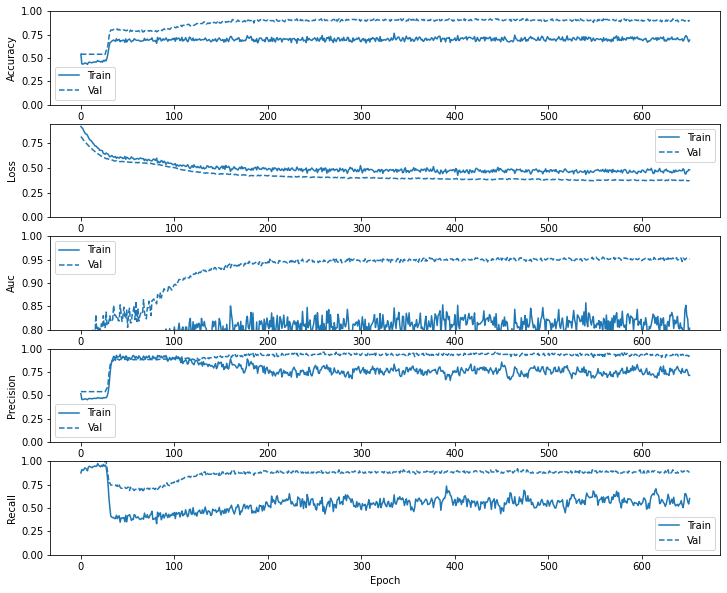

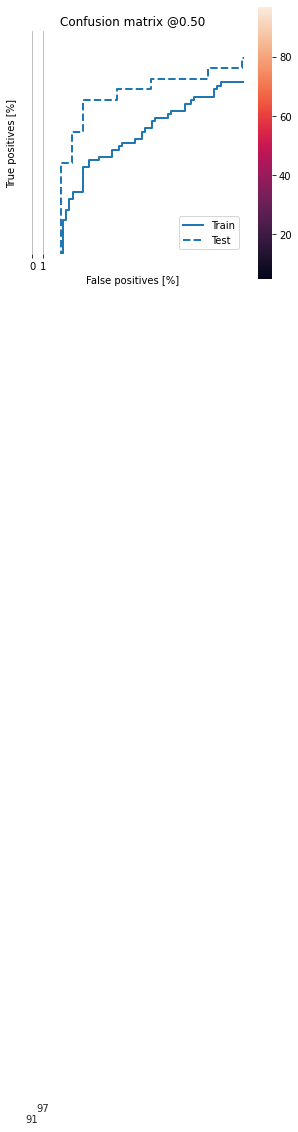

In [20]:
%%time
expId = 102
desc = str(expId) + " AngleEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_102, history_102 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 823s 63s/step - loss: 0.6886 - tp: 211.3571 - fp: 169.8571 - tn: 116.6429 - fn: 71.0000 - accuracy: 0.6067 - precision: 0.5807 - recall: 0.7730 - auc: 0.7467 - val_loss: 0.6757 - val_tp: 73.0000 - val_fp: 50.0000 - val_tn: 23.0000 - val_fn: 13.0000 - val_accuracy: 0.6038 - val_precision: 0.5935 - val_recall: 0.8488 - val_auc: 0.6543
Epoch 2/10000
13/13 [==============================] - 825s 63s/step - loss: 0.6856 - tp: 79.2857 - fp: 116.4286 - tn: 75.5000 - fn: 98.6429 - accuracy: 0.4044 - precision: 0.3952 - recall: 0.4735 - auc: 0.4146 - val_loss: 0.6721 - val_tp: 50.0000 - val_fp: 20.0000 - val_tn: 53.0000 - val_fn: 36.0000 - val_accuracy: 0.6478 - val_precision: 0.7143 - val_recall: 0.5814 - val_auc: 0.6899
Epoch 3/10000
13/13 [==============================] - 825s 63s/step - loss: 0.6724 - tp: 51.1429 - fp: 34.4286 - tn: 159.3571 - fn: 124.9286 - accuracy: 0.5668 - precision: 0.5705 - recall: 0.2993 - auc: 0.4563 - val_loss

13/13 [==============================] - 827s 64s/step - loss: 0.6099 - tp: 60.9286 - fp: 7.2143 - tn: 184.5714 - fn: 117.1429 - accuracy: 0.6651 - precision: 0.9044 - recall: 0.3383 - auc: 0.7462 - val_loss: 0.5876 - val_tp: 45.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 41.0000 - val_accuracy: 0.7233 - val_precision: 0.9375 - val_recall: 0.5233 - val_auc: 0.8446
Epoch 44/10000
13/13 [==============================] - 827s 64s/step - loss: 0.6110 - tp: 59.4286 - fp: 5.4286 - tn: 187.8571 - fn: 117.1429 - accuracy: 0.6709 - precision: 0.8918 - recall: 0.3357 - auc: 0.7267 - val_loss: 0.5872 - val_tp: 45.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 41.0000 - val_accuracy: 0.7233 - val_precision: 0.9375 - val_recall: 0.5233 - val_auc: 0.8364
Epoch 45/10000
13/13 [==============================] - 826s 64s/step - loss: 0.5987 - tp: 69.7857 - fp: 6.7143 - tn: 184.5714 - fn: 108.7857 - accuracy: 0.6797 - precision: 0.9036 - recall: 0.3806 - auc: 0.7175 - val_loss: 0.5854 - val_tp

13/13 [==============================] - 827s 64s/step - loss: 0.5856 - tp: 74.7857 - fp: 7.4286 - tn: 186.2143 - fn: 101.4286 - accuracy: 0.7036 - precision: 0.9112 - recall: 0.4092 - auc: 0.6837 - val_loss: 0.5588 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.8981
Epoch 86/10000
13/13 [==============================] - 827s 64s/step - loss: 0.5705 - tp: 86.7857 - fp: 6.7143 - tn: 179.2143 - fn: 97.1429 - accuracy: 0.7152 - precision: 0.9298 - recall: 0.4702 - auc: 0.7215 - val_loss: 0.5587 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.8895
Epoch 87/10000
13/13 [==============================] - 827s 64s/step - loss: 0.5659 - tp: 77.8571 - fp: 9.4286 - tn: 180.2143 - fn: 102.3571 - accuracy: 0.7089 - precision: 0.8922 - recall: 0.4611 - auc: 0.7075 - val_loss: 0.5572 - val_tp:

13/13 [==============================] - 827s 64s/step - loss: 0.5628 - tp: 82.7857 - fp: 7.9286 - tn: 178.7857 - fn: 100.3571 - accuracy: 0.7103 - precision: 0.9206 - recall: 0.4680 - auc: 0.7340 - val_loss: 0.5442 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.9060
Epoch 128/10000
13/13 [==============================] - 829s 64s/step - loss: 0.5654 - tp: 79.3571 - fp: 8.8571 - tn: 181.4286 - fn: 100.2143 - accuracy: 0.7011 - precision: 0.9032 - recall: 0.4402 - auc: 0.7258 - val_loss: 0.5459 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.8909
Epoch 129/10000
13/13 [==============================] - 828s 64s/step - loss: 0.5786 - tp: 81.3571 - fp: 8.0714 - tn: 176.4286 - fn: 104.0000 - accuracy: 0.6959 - precision: 0.9303 - recall: 0.4424 - auc: 0.7165 - val_loss: 0.5415 - val_

13/13 [==============================] - 828s 64s/step - loss: 0.5544 - tp: 88.3571 - fp: 6.2857 - tn: 184.7143 - fn: 90.5000 - accuracy: 0.7330 - precision: 0.9475 - recall: 0.4837 - auc: 0.7177 - val_loss: 0.5295 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9070
Epoch 170/10000
13/13 [==============================] - 830s 64s/step - loss: 0.5502 - tp: 85.6429 - fp: 7.2857 - tn: 187.0714 - fn: 89.8571 - accuracy: 0.7367 - precision: 0.9107 - recall: 0.4831 - auc: 0.7107 - val_loss: 0.5287 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9235
Epoch 171/10000
13/13 [==============================] - 828s 64s/step - loss: 0.5357 - tp: 84.9286 - fp: 7.0000 - tn: 187.5000 - fn: 90.4286 - accuracy: 0.7425 - precision: 0.9238 - recall: 0.4961 - auc: 0.7591 - val_loss: 0.5284 - val_tp:

13/13 [==============================] - 827s 64s/step - loss: 0.5348 - tp: 91.3571 - fp: 2.7857 - tn: 188.3571 - fn: 87.3571 - accuracy: 0.7525 - precision: 0.9735 - recall: 0.5013 - auc: 0.7311 - val_loss: 0.5157 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.9090
Epoch 212/10000
13/13 [==============================] - 831s 64s/step - loss: 0.5667 - tp: 78.4286 - fp: 11.0000 - tn: 182.4286 - fn: 98.0000 - accuracy: 0.6995 - precision: 0.8750 - recall: 0.4381 - auc: 0.7262 - val_loss: 0.5142 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9284
Epoch 213/10000
13/13 [==============================] - 827s 64s/step - loss: 0.5495 - tp: 87.5714 - fp: 8.2857 - tn: 183.0000 - fn: 91.0000 - accuracy: 0.7261 - precision: 0.9028 - recall: 0.4770 - auc: 0.7323 - val_loss: 0.5140 - val_tp

13/13 [==============================] - 827s 64s/step - loss: 0.5146 - tp: 93.2143 - fp: 5.7143 - tn: 188.0714 - fn: 82.8571 - accuracy: 0.7643 - precision: 0.9340 - recall: 0.5369 - auc: 0.7714 - val_loss: 0.5145 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.9239
Epoch 254/10000
13/13 [==============================] - 829s 64s/step - loss: 0.5087 - tp: 96.4286 - fp: 7.6429 - tn: 182.2857 - fn: 83.5000 - accuracy: 0.7561 - precision: 0.9168 - recall: 0.5386 - auc: 0.7711 - val_loss: 0.5145 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9145
Epoch 255/10000
13/13 [==============================] - 826s 64s/step - loss: 0.5203 - tp: 93.0714 - fp: 4.1429 - tn: 185.4286 - fn: 87.2143 - accuracy: 0.7568 - precision: 0.9680 - recall: 0.5148 - auc: 0.7652 - val_loss: 0.5136 - val_tp:

13/13 [==============================] - 828s 64s/step - loss: 0.5160 - tp: 96.9286 - fp: 11.7857 - tn: 177.3571 - fn: 83.7857 - accuracy: 0.7443 - precision: 0.8871 - recall: 0.5424 - auc: 0.7578 - val_loss: 0.5213 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9254
Epoch 296/10000
13/13 [==============================] - 825s 63s/step - loss: 0.5503 - tp: 90.7857 - fp: 8.7143 - tn: 182.5714 - fn: 87.7857 - accuracy: 0.7234 - precision: 0.8938 - recall: 0.4885 - auc: 0.7694 - val_loss: 0.5230 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9207
Epoch 297/10000
13/13 [==============================] - 826s 64s/step - loss: 0.5044 - tp: 95.1429 - fp: 5.7143 - tn: 186.8571 - fn: 82.1429 - accuracy: 0.7640 - precision: 0.9399 - recall: 0.5464 - auc: 0.8091 - val_loss: 0.5219 - val_tp

13/13 [==============================] - 826s 64s/step - loss: 0.5274 - tp: 86.2857 - fp: 9.4286 - tn: 190.5000 - fn: 83.6429 - accuracy: 0.7423 - precision: 0.8839 - recall: 0.4946 - auc: 0.7506 - val_loss: 0.5377 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9390
Epoch 338/10000
13/13 [==============================] - 825s 63s/step - loss: 0.5344 - tp: 82.2857 - fp: 5.3571 - tn: 191.0714 - fn: 91.1429 - accuracy: 0.7460 - precision: 0.9482 - recall: 0.4738 - auc: 0.7452 - val_loss: 0.5338 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9266
Epoch 339/10000
13/13 [==============================] - 827s 64s/step - loss: 0.5127 - tp: 100.1429 - fp: 6.5000 - tn: 182.1429 - fn: 81.0714 - accuracy: 0.7561 - precision: 0.9451 - recall: 0.5470 - auc: 0.7761 - val_loss: 0.5363 - val_tp

13/13 [==============================] - 825s 64s/step - loss: 0.4987 - tp: 102.1429 - fp: 4.7857 - tn: 187.3571 - fn: 75.5714 - accuracy: 0.7831 - precision: 0.9579 - recall: 0.5790 - auc: 0.7807 - val_loss: 0.5347 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9393
Epoch 380/10000
13/13 [==============================] - 826s 64s/step - loss: 0.5191 - tp: 95.0000 - fp: 7.3571 - tn: 187.2143 - fn: 80.2857 - accuracy: 0.7639 - precision: 0.9162 - recall: 0.5497 - auc: 0.7671 - val_loss: 0.5298 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9372
Epoch 381/10000
13/13 [==============================] - 825s 63s/step - loss: 0.4770 - tp: 106.2857 - fp: 6.0714 - tn: 188.0714 - fn: 69.4286 - accuracy: 0.7952 - precision: 0.9443 - recall: 0.6082 - auc: 0.7994 - val_loss: 0.5323 - val_t

13/13 [==============================] - 827s 64s/step - loss: 0.4847 - tp: 101.3571 - fp: 3.7143 - tn: 191.1429 - fn: 73.6429 - accuracy: 0.7959 - precision: 0.9643 - recall: 0.5832 - auc: 0.7832 - val_loss: 0.5275 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9363
Epoch 422/10000
13/13 [==============================] - 826s 64s/step - loss: 0.4999 - tp: 107.9286 - fp: 8.5714 - tn: 183.4286 - fn: 69.9286 - accuracy: 0.7821 - precision: 0.9056 - recall: 0.6009 - auc: 0.7959 - val_loss: 0.5260 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9415
Epoch 423/10000
13/13 [==============================] - 825s 63s/step - loss: 0.5445 - tp: 98.4286 - fp: 7.0000 - tn: 176.6429 - fn: 87.7857 - accuracy: 0.7277 - precision: 0.9256 - recall: 0.5185 - auc: 0.7676 - val_loss: 0.5245 - val_t

13/13 [==============================] - 826s 64s/step - loss: 0.4945 - tp: 96.2143 - fp: 5.0714 - tn: 187.2143 - fn: 81.3571 - accuracy: 0.7729 - precision: 0.9584 - recall: 0.5515 - auc: 0.8040 - val_loss: 0.5082 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9456
Epoch 464/10000
13/13 [==============================] - 826s 64s/step - loss: 0.4932 - tp: 103.6429 - fp: 6.5714 - tn: 182.0000 - fn: 77.6429 - accuracy: 0.7772 - precision: 0.9461 - recall: 0.5790 - auc: 0.7987 - val_loss: 0.5115 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9433
Epoch 465/10000
13/13 [==============================] - 826s 63s/step - loss: 0.4551 - tp: 115.5000 - fp: 6.0714 - tn: 187.5000 - fn: 60.7857 - accuracy: 0.8258 - precision: 0.9517 - recall: 0.6621 - auc: 0.8268 - val_loss: 0.5124 - val_t

13/13 [==============================] - 826s 64s/step - loss: 0.5075 - tp: 107.7143 - fp: 6.0000 - tn: 177.6429 - fn: 78.5000 - accuracy: 0.7556 - precision: 0.9437 - recall: 0.5659 - auc: 0.7747 - val_loss: 0.5160 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9313
Epoch 506/10000
13/13 [==============================] - 829s 64s/step - loss: 0.4832 - tp: 110.4286 - fp: 5.3571 - tn: 184.9286 - fn: 69.1429 - accuracy: 0.7960 - precision: 0.9487 - recall: 0.6004 - auc: 0.7715 - val_loss: 0.5127 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9309
Epoch 507/10000
13/13 [==============================] - 827s 64s/step - loss: 0.4898 - tp: 104.2857 - fp: 7.7857 - tn: 185.7143 - fn: 72.0714 - accuracy: 0.7806 - precision: 0.9257 - recall: 0.5761 - auc: 0.7849 - val_loss: 0.5105 - val_

13/13 [==============================] - 828s 64s/step - loss: 0.4744 - tp: 115.3571 - fp: 9.7857 - tn: 180.7143 - fn: 64.0000 - accuracy: 0.7982 - precision: 0.9220 - recall: 0.6440 - auc: 0.8054 - val_loss: 0.5061 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9358
Epoch 548/10000
13/13 [==============================] - 826s 64s/step - loss: 0.4609 - tp: 107.2143 - fp: 7.7857 - tn: 186.5000 - fn: 68.3571 - accuracy: 0.8070 - precision: 0.9357 - recall: 0.6346 - auc: 0.8051 - val_loss: 0.5067 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9362
Epoch 549/10000
13/13 [==============================] - 828s 64s/step - loss: 0.5016 - tp: 107.2143 - fp: 7.1429 - tn: 180.6429 - fn: 74.8571 - accuracy: 0.7711 - precision: 0.9354 - recall: 0.5701 - auc: 0.7438 - val_loss: 0.5047 - val_

13/13 [==============================] - 885s 68s/step - loss: 0.4660 - tp: 110.8571 - fp: 3.8571 - tn: 190.9286 - fn: 64.2143 - accuracy: 0.8181 - precision: 0.9747 - recall: 0.6192 - auc: 0.7894 - val_loss: 0.4917 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9461
Epoch 590/10000
13/13 [==============================] - 884s 68s/step - loss: 0.4938 - tp: 107.0000 - fp: 8.7143 - tn: 177.7143 - fn: 76.4286 - accuracy: 0.7788 - precision: 0.9332 - recall: 0.5984 - auc: 0.7918 - val_loss: 0.4922 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9441
Epoch 591/10000
13/13 [==============================] - 888s 68s/step - loss: 0.4515 - tp: 108.5000 - fp: 2.8571 - tn: 191.7143 - fn: 66.7857 - accuracy: 0.8175 - precision: 0.9819 - recall: 0.6260 - auc: 0.8008 - val_loss: 0.4946 - val_

13/13 [==============================] - 889s 68s/step - loss: 0.5069 - tp: 100.5000 - fp: 6.4286 - tn: 185.8571 - fn: 77.0714 - accuracy: 0.7684 - precision: 0.9332 - recall: 0.5505 - auc: 0.7795 - val_loss: 0.4888 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9431
Epoch 632/10000
13/13 [==============================] - 886s 68s/step - loss: 0.4787 - tp: 103.0714 - fp: 3.9286 - tn: 189.7857 - fn: 73.0714 - accuracy: 0.7961 - precision: 0.9647 - recall: 0.5880 - auc: 0.7745 - val_loss: 0.4865 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9421
Epoch 633/10000
13/13 [==============================] - 884s 68s/step - loss: 0.4448 - tp: 118.2143 - fp: 4.3571 - tn: 185.7857 - fn: 61.5000 - accuracy: 0.8251 - precision: 0.9704 - recall: 0.6683 - auc: 0.8197 - val_loss: 0.4904 - val_

13/13 [==============================] - 886s 68s/step - loss: 0.5082 - tp: 104.9286 - fp: 6.1429 - tn: 178.1429 - fn: 80.6429 - accuracy: 0.7594 - precision: 0.9506 - recall: 0.5645 - auc: 0.7577 - val_loss: 0.4923 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9459
Epoch 674/10000
13/13 [==============================] - 886s 68s/step - loss: 0.4429 - tp: 113.2143 - fp: 5.7857 - tn: 188.2857 - fn: 62.5714 - accuracy: 0.8187 - precision: 0.9571 - recall: 0.6407 - auc: 0.8076 - val_loss: 0.4907 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9403
Epoch 675/10000
13/13 [==============================] - 887s 68s/step - loss: 0.4420 - tp: 112.0714 - fp: 5.9286 - tn: 193.0714 - fn: 58.7857 - accuracy: 0.8345 - precision: 0.9488 - recall: 0.6697 - auc: 0.8305 - val_loss: 0.4893 - val_

13/13 [==============================] - 885s 68s/step - loss: 0.4329 - tp: 118.2857 - fp: 7.2857 - tn: 183.7857 - fn: 60.5000 - accuracy: 0.8259 - precision: 0.9511 - recall: 0.6764 - auc: 0.8357 - val_loss: 0.4843 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9442
Epoch 716/10000
13/13 [==============================] - 884s 68s/step - loss: 0.4557 - tp: 112.0714 - fp: 11.0714 - tn: 178.9286 - fn: 67.7857 - accuracy: 0.7886 - precision: 0.9075 - recall: 0.6315 - auc: 0.7814 - val_loss: 0.4816 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9447
Epoch 717/10000
13/13 [==============================] - 891s 69s/step - loss: 0.4857 - tp: 103.8571 - fp: 8.9286 - tn: 186.3571 - fn: 70.7143 - accuracy: 0.7811 - precision: 0.9265 - recall: 0.5864 - auc: 0.7641 - val_loss: 0.4897 - val

13/13 [==============================] - 885s 68s/step - loss: 0.4650 - tp: 111.8571 - fp: 5.4286 - tn: 181.2143 - fn: 71.3571 - accuracy: 0.7942 - precision: 0.9631 - recall: 0.6145 - auc: 0.7915 - val_loss: 0.4792 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9408
Epoch 758/10000
13/13 [==============================] - 884s 68s/step - loss: 0.4807 - tp: 107.0000 - fp: 5.8571 - tn: 186.9286 - fn: 70.0714 - accuracy: 0.7914 - precision: 0.9470 - recall: 0.5901 - auc: 0.7627 - val_loss: 0.4861 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9452
Epoch 759/10000
13/13 [==============================] - 884s 68s/step - loss: 0.4702 - tp: 107.0714 - fp: 4.5000 - tn: 184.3571 - fn: 73.9286 - accuracy: 0.7962 - precision: 0.9607 - recall: 0.6138 - auc: 0.8181 - val_loss: 0.4834 - val_

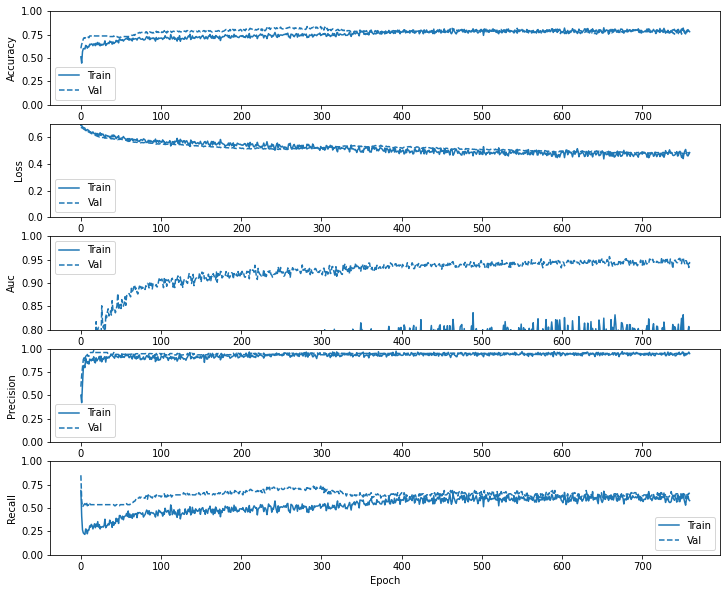

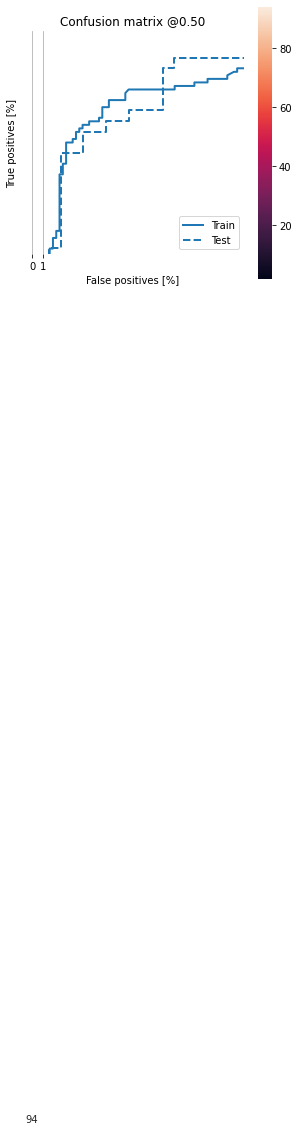

In [21]:
%%time
expId = 103
desc = str(expId) + " AngleEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_103, history_103 = runTheExperiments(expId, desc)

## IQPEmbedding

Epoch 1/10000
13/13 [==============================] - 542s 42s/step - loss: 0.6996 - tp: 120.7857 - fp: 46.2143 - tn: 240.2857 - fn: 161.5714 - accuracy: 0.6544 - precision: 0.7438 - recall: 0.4566 - auc: 0.7242 - val_loss: 0.7065 - val_tp: 25.0000 - val_fp: 18.0000 - val_tn: 55.0000 - val_fn: 61.0000 - val_accuracy: 0.5031 - val_precision: 0.5814 - val_recall: 0.2907 - val_auc: 0.4682
Epoch 2/10000
13/13 [==============================] - 542s 42s/step - loss: 0.7029 - tp: 44.6429 - fp: 44.0714 - tn: 147.8571 - fn: 133.2857 - accuracy: 0.5286 - precision: 0.5032 - recall: 0.2640 - auc: 0.4890 - val_loss: 0.7125 - val_tp: 19.0000 - val_fp: 22.0000 - val_tn: 51.0000 - val_fn: 67.0000 - val_accuracy: 0.4403 - val_precision: 0.4634 - val_recall: 0.2209 - val_auc: 0.4167
Epoch 3/10000
13/13 [==============================] - 544s 42s/step - loss: 0.7107 - tp: 50.2857 - fp: 36.2857 - tn: 157.5000 - fn: 125.7857 - accuracy: 0.5742 - precision: 0.5837 - recall: 0.2895 - auc: 0.4733 - val_los

13/13 [==============================] - 544s 42s/step - loss: 0.6739 - tp: 49.2857 - fp: 10.5000 - tn: 181.2857 - fn: 128.7857 - accuracy: 0.6245 - precision: 0.8397 - recall: 0.2696 - auc: 0.6038 - val_loss: 0.7858 - val_tp: 0.0000e+00 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 86.0000 - val_accuracy: 0.4277 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.1961
Epoch 44/10000
13/13 [==============================] - 545s 42s/step - loss: 0.6812 - tp: 35.7143 - fp: 3.6429 - tn: 189.6429 - fn: 140.8571 - accuracy: 0.6151 - precision: 0.9131 - recall: 0.1934 - auc: 0.5407 - val_loss: 0.7857 - val_tp: 2.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 84.0000 - val_accuracy: 0.4465 - val_precision: 0.3333 - val_recall: 0.0233 - val_auc: 0.2117
Epoch 45/10000
13/13 [==============================] - 546s 42s/step - loss: 0.6841 - tp: 43.7143 - fp: 6.2143 - tn: 185.0714 - fn: 134.8571 - accuracy: 0.6092 - precision: 0.8595 - recall: 0.2313 - auc: 0.5164 - val_loss: 0.79

Epoch 64/10000
13/13 [==============================] - 547s 42s/step - loss: 0.6697 - tp: 48.1429 - fp: 5.9286 - tn: 185.7143 - fn: 130.0714 - accuracy: 0.6204 - precision: 0.8922 - recall: 0.2509 - auc: 0.6231 - val_loss: 0.7937 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 73.0000 - val_fn: 86.0000 - val_accuracy: 0.4591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2182
Epoch 65/10000
13/13 [==============================] - 544s 42s/step - loss: 0.6707 - tp: 44.6429 - fp: 4.2143 - tn: 187.3571 - fn: 133.6429 - accuracy: 0.6252 - precision: 0.9073 - recall: 0.2448 - auc: 0.5592 - val_loss: 0.7938 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 73.0000 - val_fn: 86.0000 - val_accuracy: 0.4591 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2030
Epoch 66/10000
13/13 [==============================] - 546s 42s/step - loss: 0.6737 - tp: 41.3571 - fp: 4.5000 - tn: 188.1429 - fn: 135.8571 - accuracy: 0.6284 - precision: 0.9092 - recall: 0.2

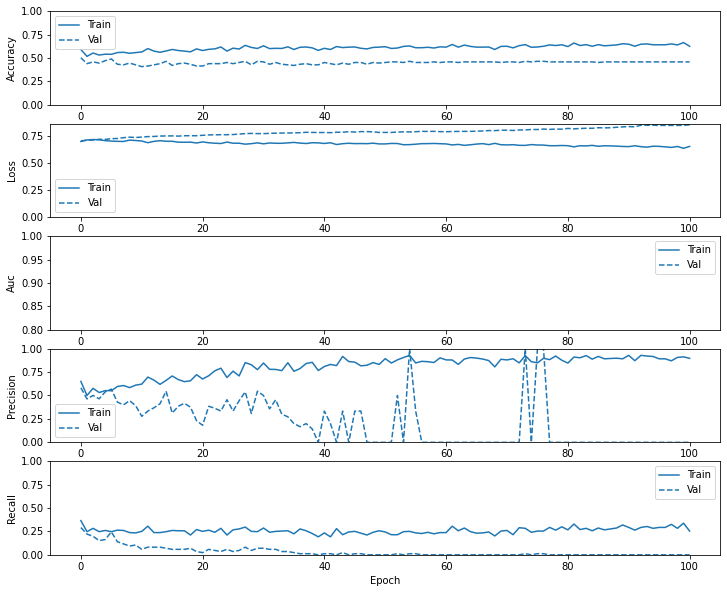

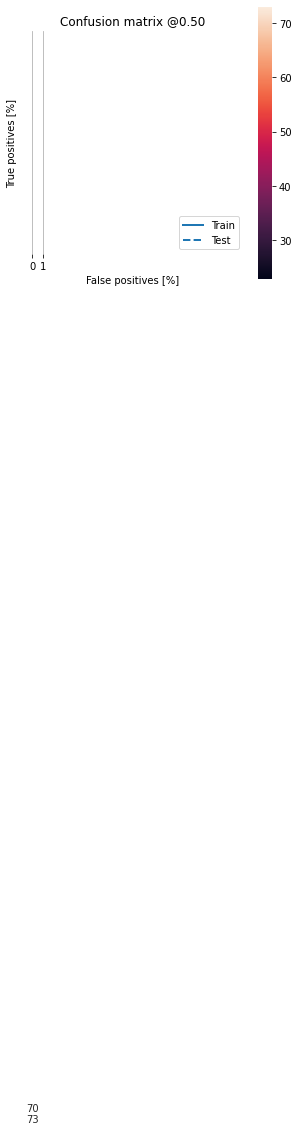

In [22]:
%%time
expId = 104
desc = str(expId) + " IQPEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_104, history_104 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 523s 40s/step - loss: 0.7329 - tp: 63.7857 - fp: 60.5714 - tn: 225.9286 - fn: 218.5714 - accuracy: 0.5100 - precision: 0.5163 - recall: 0.2305 - auc: 0.4439 - val_loss: 0.7654 - val_tp: 4.0000 - val_fp: 19.0000 - val_tn: 54.0000 - val_fn: 82.0000 - val_accuracy: 0.3648 - val_precision: 0.1739 - val_recall: 0.0465 - val_auc: 0.2061
Epoch 2/10000
13/13 [==============================] - 522s 40s/step - loss: 0.7293 - tp: 40.5000 - fp: 34.8571 - tn: 157.0714 - fn: 137.4286 - accuracy: 0.5421 - precision: 0.5356 - recall: 0.2336 - auc: 0.4490 - val_loss: 0.7629 - val_tp: 7.0000 - val_fp: 16.0000 - val_tn: 57.0000 - val_fn: 79.0000 - val_accuracy: 0.4025 - val_precision: 0.3043 - val_recall: 0.0814 - val_auc: 0.2080
Epoch 3/10000
13/13 [==============================] - 521s 40s/step - loss: 0.7154 - tp: 46.7143 - fp: 38.1429 - tn: 155.6429 - fn: 129.3571 - accuracy: 0.5542 - precision: 0.5373 - recall: 0.2619 - auc: 0.4530 - val_loss: 

13/13 [==============================] - 524s 40s/step - loss: 0.6832 - tp: 45.9286 - fp: 46.7143 - tn: 145.0714 - fn: 132.1429 - accuracy: 0.5181 - precision: 0.4937 - recall: 0.2451 - auc: 0.5678 - val_loss: 0.6857 - val_tp: 21.0000 - val_fp: 13.0000 - val_tn: 60.0000 - val_fn: 65.0000 - val_accuracy: 0.5094 - val_precision: 0.6176 - val_recall: 0.2442 - val_auc: 0.5629
Epoch 44/10000
13/13 [==============================] - 522s 40s/step - loss: 0.6859 - tp: 51.7857 - fp: 46.8571 - tn: 146.4286 - fn: 124.7857 - accuracy: 0.5439 - precision: 0.5198 - recall: 0.3072 - auc: 0.5326 - val_loss: 0.6846 - val_tp: 13.0000 - val_fp: 13.0000 - val_tn: 60.0000 - val_fn: 73.0000 - val_accuracy: 0.4591 - val_precision: 0.5000 - val_recall: 0.1512 - val_auc: 0.5825
Epoch 45/10000
13/13 [==============================] - 522s 40s/step - loss: 0.6834 - tp: 49.8571 - fp: 45.2857 - tn: 146.0000 - fn: 128.7143 - accuracy: 0.5266 - precision: 0.5223 - recall: 0.2770 - auc: 0.5464 - val_loss: 0.6863 - v

13/13 [==============================] - 524s 40s/step - loss: 0.6285 - tp: 135.7857 - fp: 98.7143 - tn: 94.9286 - fn: 40.4286 - accuracy: 0.6107 - precision: 0.5638 - recall: 0.7704 - auc: 0.6668 - val_loss: 0.5988 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9247
Epoch 86/10000
13/13 [==============================] - 524s 40s/step - loss: 0.6088 - tp: 148.9286 - fp: 77.8571 - tn: 108.0714 - fn: 35.0000 - accuracy: 0.7017 - precision: 0.6657 - recall: 0.8179 - auc: 0.7514 - val_loss: 0.5984 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9295
Epoch 87/10000
13/13 [==============================] - 524s 40s/step - loss: 0.6147 - tp: 146.1429 - fp: 85.0714 - tn: 104.5714 - fn: 34.0714 - accuracy: 0.6761 - precision: 0.6320 - recall: 0.8093 - auc: 0.7130 - val_loss: 0.5936 - val_

13/13 [==============================] - 524s 40s/step - loss: 0.5931 - tp: 170.2857 - fp: 96.4286 - tn: 90.2857 - fn: 12.8571 - accuracy: 0.7083 - precision: 0.6471 - recall: 0.9349 - auc: 0.7333 - val_loss: 0.5527 - val_tp: 71.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 15.0000 - val_accuracy: 0.8805 - val_precision: 0.9467 - val_recall: 0.8256 - val_auc: 0.9486
Epoch 128/10000
13/13 [==============================] - 520s 40s/step - loss: 0.5956 - tp: 161.7143 - fp: 98.4286 - tn: 91.8571 - fn: 17.8571 - accuracy: 0.6890 - precision: 0.6277 - recall: 0.9042 - auc: 0.6982 - val_loss: 0.5507 - val_tp: 70.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 16.0000 - val_accuracy: 0.8805 - val_precision: 0.9589 - val_recall: 0.8140 - val_auc: 0.9427
Epoch 129/10000
13/13 [==============================] - 521s 40s/step - loss: 0.5870 - tp: 173.9286 - fp: 92.3571 - tn: 92.1429 - fn: 11.4286 - accuracy: 0.7221 - precision: 0.6621 - recall: 0.9401 - auc: 0.7143 - val_loss: 0.5496 - val_

13/13 [==============================] - 524s 40s/step - loss: 0.5713 - tp: 164.6429 - fp: 95.0714 - tn: 95.9286 - fn: 14.2143 - accuracy: 0.7086 - precision: 0.6404 - recall: 0.9242 - auc: 0.7412 - val_loss: 0.5232 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9525
Epoch 170/10000
13/13 [==============================] - 523s 40s/step - loss: 0.5862 - tp: 161.2143 - fp: 101.6429 - tn: 92.7143 - fn: 14.2857 - accuracy: 0.6838 - precision: 0.6072 - recall: 0.9129 - auc: 0.7235 - val_loss: 0.5228 - val_tp: 73.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 13.0000 - val_accuracy: 0.8931 - val_precision: 0.9481 - val_recall: 0.8488 - val_auc: 0.9499
Epoch 171/10000
13/13 [==============================] - 524s 40s/step - loss: 0.5725 - tp: 164.5714 - fp: 101.0714 - tn: 93.4286 - fn: 10.7857 - accuracy: 0.6968 - precision: 0.6174 - recall: 0.9432 - auc: 0.7169 - val_loss: 0.5214 - va

13/13 [==============================] - 521s 40s/step - loss: 0.5877 - tp: 162.2857 - fp: 104.0714 - tn: 87.0714 - fn: 16.4286 - accuracy: 0.6672 - precision: 0.6031 - recall: 0.9101 - auc: 0.6989 - val_loss: 0.5005 - val_tp: 74.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 12.0000 - val_accuracy: 0.8994 - val_precision: 0.9487 - val_recall: 0.8605 - val_auc: 0.9453
Epoch 212/10000
13/13 [==============================] - 523s 40s/step - loss: 0.5824 - tp: 163.9286 - fp: 102.9286 - tn: 90.5000 - fn: 12.5000 - accuracy: 0.6770 - precision: 0.6080 - recall: 0.9221 - auc: 0.6806 - val_loss: 0.5025 - val_tp: 73.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 13.0000 - val_accuracy: 0.8931 - val_precision: 0.9481 - val_recall: 0.8488 - val_auc: 0.9445
Epoch 213/10000
13/13 [==============================] - 521s 40s/step - loss: 0.5694 - tp: 170.6429 - fp: 104.5714 - tn: 86.7143 - fn: 7.9286 - accuracy: 0.6945 - precision: 0.6160 - recall: 0.9590 - auc: 0.7328 - val_loss: 0.5006 - va

13/13 [==============================] - 522s 40s/step - loss: 0.5846 - tp: 161.2143 - fp: 106.6429 - tn: 87.1429 - fn: 14.8571 - accuracy: 0.6657 - precision: 0.5926 - recall: 0.9211 - auc: 0.6916 - val_loss: 0.4943 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9435
Epoch 254/10000
13/13 [==============================] - 522s 40s/step - loss: 0.5452 - tp: 166.7143 - fp: 88.3571 - tn: 101.5714 - fn: 13.2143 - accuracy: 0.7262 - precision: 0.6478 - recall: 0.9388 - auc: 0.7382 - val_loss: 0.4820 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9537
Epoch 255/10000
13/13 [==============================] - 523s 40s/step - loss: 0.5838 - tp: 163.6429 - fp: 98.9286 - tn: 90.6429 - fn: 16.6429 - accuracy: 0.6885 - precision: 0.6225 - recall: 0.9080 - auc: 0.6790 - val_loss: 0.4941 - va

13/13 [==============================] - 523s 40s/step - loss: 0.5838 - tp: 169.7857 - fp: 104.8571 - tn: 84.2857 - fn: 10.9286 - accuracy: 0.6752 - precision: 0.6071 - recall: 0.9384 - auc: 0.6775 - val_loss: 0.4781 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9415
Epoch 296/10000
13/13 [==============================] - 523s 40s/step - loss: 0.5577 - tp: 168.2857 - fp: 94.8571 - tn: 96.4286 - fn: 10.2857 - accuracy: 0.7169 - precision: 0.6406 - recall: 0.9488 - auc: 0.7263 - val_loss: 0.4798 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9415
Epoch 297/10000
13/13 [==============================] - 522s 40s/step - loss: 0.5649 - tp: 160.1429 - fp: 100.1429 - tn: 92.4286 - fn: 17.1429 - accuracy: 0.6844 - precision: 0.6180 - recall: 0.9077 - auc: 0.7104 - val_loss: 0.4756 - va

13/13 [==============================] - 522s 40s/step - loss: 0.5496 - tp: 158.2857 - fp: 97.7857 - tn: 102.1429 - fn: 11.6429 - accuracy: 0.6974 - precision: 0.6094 - recall: 0.9201 - auc: 0.7206 - val_loss: 0.4716 - val_tp: 78.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 8.0000 - val_accuracy: 0.8994 - val_precision: 0.9070 - val_recall: 0.9070 - val_auc: 0.9387
Epoch 338/10000
13/13 [==============================] - 524s 40s/step - loss: 0.5417 - tp: 166.0714 - fp: 100.4286 - tn: 96.0000 - fn: 7.3571 - accuracy: 0.7095 - precision: 0.6180 - recall: 0.9635 - auc: 0.7542 - val_loss: 0.4678 - val_tp: 78.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 8.0000 - val_accuracy: 0.9119 - val_precision: 0.9286 - val_recall: 0.9070 - val_auc: 0.9500
Epoch 339/10000
13/13 [==============================] - 521s 40s/step - loss: 0.5533 - tp: 168.6429 - fp: 96.8571 - tn: 91.7857 - fn: 12.5714 - accuracy: 0.7090 - precision: 0.6448 - recall: 0.9298 - auc: 0.7351 - val_loss: 0.4681 - val_t

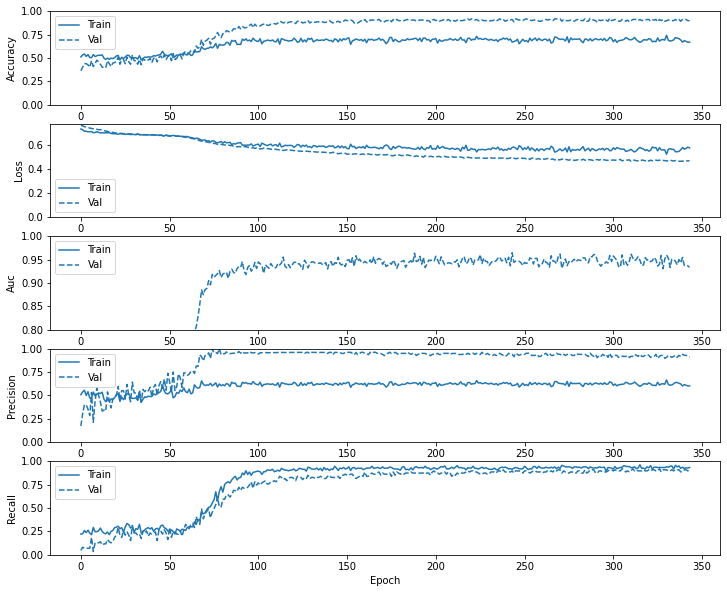

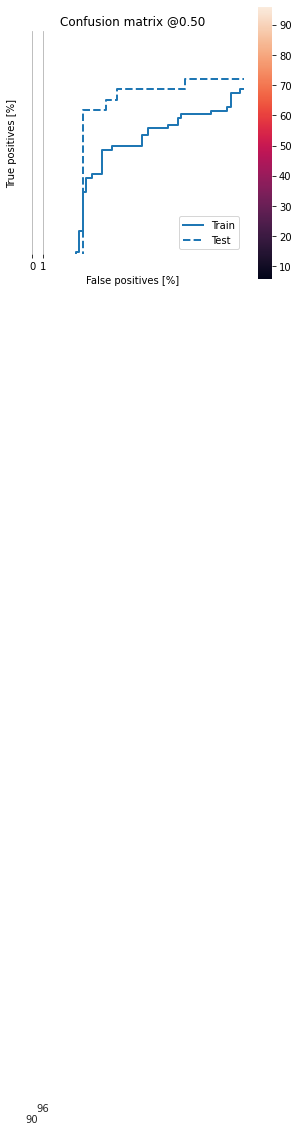

In [23]:
%%time
expId = 105
desc = str(expId) + " IQPEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_105, history_105 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 814s 63s/step - loss: 0.7315 - tp: 160.7143 - fp: 186.2143 - tn: 4.2857 - fn: 18.6429 - accuracy: 0.4457 - precision: 0.4604 - recall: 0.8975 - auc: 0.5087 - val_loss: 0.7257 - val_tp: 71.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 15.0000 - val_accuracy: 0.4465 - val_precision: 0.4931 - val_recall: 0.8256 - val_auc: 0.3136
Epoch 2/10000
13/13 [==============================] - 875s 67s/step - loss: 0.7383 - tp: 154.4286 - fp: 191.4286 - tn: 0.5000 - fn: 23.5000 - accuracy: 0.4140 - precision: 0.4399 - recall: 0.8739 - auc: 0.4567 - val_loss: 0.7235 - val_tp: 71.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 15.0000 - val_accuracy: 0.4465 - val_precision: 0.4931 - val_recall: 0.8256 - val_auc: 0.3189
Epoch 3/10000
13/13 [==============================] - 876s 67s/step - loss: 0.7468 - tp: 149.0000 - fp: 193.3571 - tn: 0.4286 - fn: 27.0714 - accuracy: 0.3948 - precision: 0.4243 - recall: 0.8495 - auc: 0.3881 - val_l

13/13 [==============================] - 879s 68s/step - loss: 0.7007 - tp: 93.4286 - fp: 107.9286 - tn: 79.6429 - fn: 88.8571 - accuracy: 0.4709 - precision: 0.4732 - recall: 0.5193 - auc: 0.4874 - val_loss: 0.7138 - val_tp: 28.0000 - val_fp: 41.0000 - val_tn: 32.0000 - val_fn: 58.0000 - val_accuracy: 0.3774 - val_precision: 0.4058 - val_recall: 0.3256 - val_auc: 0.3073
Epoch 23/10000
13/13 [==============================] - 876s 67s/step - loss: 0.6934 - tp: 100.0000 - fp: 100.5714 - tn: 87.8571 - fn: 81.4286 - accuracy: 0.5157 - precision: 0.5098 - recall: 0.5650 - auc: 0.5519 - val_loss: 0.7123 - val_tp: 28.0000 - val_fp: 42.0000 - val_tn: 31.0000 - val_fn: 58.0000 - val_accuracy: 0.3711 - val_precision: 0.4000 - val_recall: 0.3256 - val_auc: 0.3367
Epoch 24/10000
13/13 [==============================] - 877s 67s/step - loss: 0.6955 - tp: 86.4286 - fp: 77.2857 - tn: 116.4286 - fn: 89.7143 - accuracy: 0.5519 - precision: 0.5384 - recall: 0.4989 - auc: 0.5496 - val_loss: 0.7107 - val

13/13 [==============================] - 880s 68s/step - loss: 0.6852 - tp: 44.5714 - fp: 6.9286 - tn: 184.8571 - fn: 133.5000 - accuracy: 0.6323 - precision: 0.8711 - recall: 0.2721 - auc: 0.5649 - val_loss: 0.7102 - val_tp: 13.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 73.0000 - val_accuracy: 0.5094 - val_precision: 0.7222 - val_recall: 0.1512 - val_auc: 0.3616
Epoch 44/10000
13/13 [==============================] - 878s 67s/step - loss: 0.6837 - tp: 50.2143 - fp: 6.3571 - tn: 186.9286 - fn: 126.3571 - accuracy: 0.6720 - precision: 0.9012 - recall: 0.3368 - auc: 0.6255 - val_loss: 0.7121 - val_tp: 14.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 72.0000 - val_accuracy: 0.5283 - val_precision: 0.8235 - val_recall: 0.1628 - val_auc: 0.3433
Epoch 45/10000
13/13 [==============================] - 879s 68s/step - loss: 0.6965 - tp: 38.2143 - fp: 6.1429 - tn: 185.1429 - fn: 140.3571 - accuracy: 0.5952 - precision: 0.8318 - recall: 0.2086 - auc: 0.5291 - val_loss: 0.7115 - val_tp

13/13 [==============================] - 878s 68s/step - loss: 0.6890 - tp: 43.2857 - fp: 4.9286 - tn: 186.7143 - fn: 134.9286 - accuracy: 0.6264 - precision: 0.9049 - recall: 0.2570 - auc: 0.5531 - val_loss: 0.7142 - val_tp: 12.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 74.0000 - val_accuracy: 0.5157 - val_precision: 0.8000 - val_recall: 0.1395 - val_auc: 0.3197
Epoch 65/10000
13/13 [==============================] - 879s 68s/step - loss: 0.6893 - tp: 43.5714 - fp: 5.0000 - tn: 186.5714 - fn: 134.7143 - accuracy: 0.6206 - precision: 0.8869 - recall: 0.2416 - auc: 0.5346 - val_loss: 0.7142 - val_tp: 11.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 75.0000 - val_accuracy: 0.5094 - val_precision: 0.7857 - val_recall: 0.1279 - val_auc: 0.3306
Epoch 66/10000
13/13 [==============================] - 878s 67s/step - loss: 0.6848 - tp: 47.9286 - fp: 5.9286 - tn: 186.7143 - fn: 129.2857 - accuracy: 0.6403 - precision: 0.8945 - recall: 0.2758 - auc: 0.5908 - val_loss: 0.7105 - val_tp

13/13 [==============================] - 875s 67s/step - loss: 0.6689 - tp: 53.5000 - fp: 2.4286 - tn: 191.2143 - fn: 122.7143 - accuracy: 0.6689 - precision: 0.9642 - recall: 0.3083 - auc: 0.6191 - val_loss: 0.7153 - val_tp: 14.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 72.0000 - val_accuracy: 0.5157 - val_precision: 0.7368 - val_recall: 0.1628 - val_auc: 0.3434
Epoch 86/10000
13/13 [==============================] - 876s 67s/step - loss: 0.6711 - tp: 56.5000 - fp: 3.5714 - tn: 182.3571 - fn: 127.4286 - accuracy: 0.6449 - precision: 0.9564 - recall: 0.3089 - auc: 0.6098 - val_loss: 0.7150 - val_tp: 14.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 72.0000 - val_accuracy: 0.5283 - val_precision: 0.8235 - val_recall: 0.1628 - val_auc: 0.3794
Epoch 87/10000
13/13 [==============================] - 873s 67s/step - loss: 0.6768 - tp: 43.2857 - fp: 2.2857 - tn: 187.3571 - fn: 136.9286 - accuracy: 0.6204 - precision: 0.9401 - recall: 0.2365 - auc: 0.5973 - val_loss: 0.7135 - val_tp

13/13 [==============================] - 879s 68s/step - loss: 0.6504 - tp: 54.7143 - fp: 2.7857 - tn: 185.0714 - fn: 127.2857 - accuracy: 0.6451 - precision: 0.9518 - recall: 0.3067 - auc: 0.6403 - val_loss: 0.7396 - val_tp: 17.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 69.0000 - val_accuracy: 0.5472 - val_precision: 0.8500 - val_recall: 0.1977 - val_auc: 0.3422
Epoch 107/10000
13/13 [==============================] - 878s 68s/step - loss: 0.6403 - tp: 56.1429 - fp: 3.2143 - tn: 185.7857 - fn: 124.7143 - accuracy: 0.6581 - precision: 0.9546 - recall: 0.3122 - auc: 0.6603 - val_loss: 0.7403 - val_tp: 16.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 70.0000 - val_accuracy: 0.5346 - val_precision: 0.8000 - val_recall: 0.1860 - val_auc: 0.3529
Epoch 108/10000
13/13 [==============================] - 874s 67s/step - loss: 0.6474 - tp: 55.0000 - fp: 6.3571 - tn: 183.2143 - fn: 125.2857 - accuracy: 0.6554 - precision: 0.9042 - recall: 0.3216 - auc: 0.6278 - val_loss: 0.7413 - val_

13/13 [==============================] - 873s 67s/step - loss: 0.6035 - tp: 66.1429 - fp: 3.2857 - tn: 183.4286 - fn: 117.0000 - accuracy: 0.6723 - precision: 0.9553 - recall: 0.3708 - auc: 0.7301 - val_loss: 0.7731 - val_tp: 15.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 71.0000 - val_accuracy: 0.5346 - val_precision: 0.8333 - val_recall: 0.1744 - val_auc: 0.3875
Epoch 128/10000
13/13 [==============================] - 876s 67s/step - loss: 0.6119 - tp: 63.6429 - fp: 4.1429 - tn: 186.1429 - fn: 115.9286 - accuracy: 0.6666 - precision: 0.9403 - recall: 0.3461 - auc: 0.6768 - val_loss: 0.7755 - val_tp: 14.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 72.0000 - val_accuracy: 0.5283 - val_precision: 0.8235 - val_recall: 0.1628 - val_auc: 0.3810
Epoch 129/10000
13/13 [==============================] - 876s 67s/step - loss: 0.6168 - tp: 65.2143 - fp: 5.7857 - tn: 178.7143 - fn: 120.1429 - accuracy: 0.6520 - precision: 0.9360 - recall: 0.3496 - auc: 0.6739 - val_loss: 0.7765 - val_

13/13 [==============================] - 874s 67s/step - loss: 0.5987 - tp: 63.8571 - fp: 5.2143 - tn: 186.4286 - fn: 114.3571 - accuracy: 0.6681 - precision: 0.9105 - recall: 0.3455 - auc: 0.7506 - val_loss: 0.7809 - val_tp: 17.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 69.0000 - val_accuracy: 0.5472 - val_precision: 0.8500 - val_recall: 0.1977 - val_auc: 0.4515
Epoch 149/10000
13/13 [==============================] - 878s 68s/step - loss: 0.6052 - tp: 69.7143 - fp: 4.5000 - tn: 182.1429 - fn: 113.5000 - accuracy: 0.6738 - precision: 0.9331 - recall: 0.3797 - auc: 0.6845 - val_loss: 0.7817 - val_tp: 17.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 69.0000 - val_accuracy: 0.5472 - val_precision: 0.8500 - val_recall: 0.1977 - val_auc: 0.4665
Epoch 150/10000
13/13 [==============================] - 874s 67s/step - loss: 0.5797 - tp: 60.8571 - fp: 5.1429 - tn: 191.4286 - fn: 112.4286 - accuracy: 0.6897 - precision: 0.9330 - recall: 0.3568 - auc: 0.7525 - val_loss: 0.7737 - val_

13/13 [==============================] - 876s 67s/step - loss: 0.5888 - tp: 72.0714 - fp: 7.5714 - tn: 183.4286 - fn: 106.7857 - accuracy: 0.6842 - precision: 0.9179 - recall: 0.3918 - auc: 0.7716 - val_loss: 0.7279 - val_tp: 20.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 66.0000 - val_accuracy: 0.5660 - val_precision: 0.8696 - val_recall: 0.2326 - val_auc: 0.5915
Epoch 170/10000
13/13 [==============================] - 877s 68s/step - loss: 0.5899 - tp: 63.1429 - fp: 5.2857 - tn: 189.0714 - fn: 112.3571 - accuracy: 0.6741 - precision: 0.9170 - recall: 0.3309 - auc: 0.7551 - val_loss: 0.7259 - val_tp: 21.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 65.0000 - val_accuracy: 0.5723 - val_precision: 0.8750 - val_recall: 0.2442 - val_auc: 0.5994
Epoch 171/10000
13/13 [==============================] - 875s 67s/step - loss: 0.5592 - tp: 72.4286 - fp: 6.0000 - tn: 188.5000 - fn: 102.9286 - accuracy: 0.7178 - precision: 0.9348 - recall: 0.4321 - auc: 0.7988 - val_loss: 0.7267 - val_

13/13 [==============================] - 877s 67s/step - loss: 0.5706 - tp: 75.0714 - fp: 8.0000 - tn: 189.1429 - fn: 97.6429 - accuracy: 0.7133 - precision: 0.8996 - recall: 0.4294 - auc: 0.7643 - val_loss: 0.6717 - val_tp: 25.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 61.0000 - val_accuracy: 0.6038 - val_precision: 0.9259 - val_recall: 0.2907 - val_auc: 0.7249
Epoch 191/10000
13/13 [==============================] - 875s 67s/step - loss: 0.5441 - tp: 90.5000 - fp: 7.1429 - tn: 185.8571 - fn: 86.3571 - accuracy: 0.7566 - precision: 0.9299 - recall: 0.5291 - auc: 0.7918 - val_loss: 0.6663 - val_tp: 27.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 59.0000 - val_accuracy: 0.6101 - val_precision: 0.9000 - val_recall: 0.3140 - val_auc: 0.7419
Epoch 192/10000
13/13 [==============================] - 873s 67s/step - loss: 0.5219 - tp: 95.8571 - fp: 5.4286 - tn: 188.9286 - fn: 79.6429 - accuracy: 0.7771 - precision: 0.9574 - recall: 0.5494 - auc: 0.8094 - val_loss: 0.6711 - val_tp:

13/13 [==============================] - 876s 67s/step - loss: 0.5484 - tp: 92.5000 - fp: 4.5000 - tn: 186.6429 - fn: 86.2143 - accuracy: 0.7481 - precision: 0.9521 - recall: 0.5034 - auc: 0.7731 - val_loss: 0.6241 - val_tp: 42.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 44.0000 - val_accuracy: 0.7044 - val_precision: 0.9333 - val_recall: 0.4884 - val_auc: 0.8101
Epoch 212/10000
13/13 [==============================] - 876s 67s/step - loss: 0.5586 - tp: 91.7857 - fp: 9.3571 - tn: 184.0714 - fn: 84.6429 - accuracy: 0.7460 - precision: 0.9055 - recall: 0.5263 - auc: 0.7336 - val_loss: 0.6144 - val_tp: 45.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 41.0000 - val_accuracy: 0.7233 - val_precision: 0.9375 - val_recall: 0.5233 - val_auc: 0.8542
Epoch 213/10000
13/13 [==============================] - 875s 67s/step - loss: 0.5581 - tp: 95.7143 - fp: 7.5714 - tn: 183.7143 - fn: 82.8571 - accuracy: 0.7515 - precision: 0.9318 - recall: 0.5185 - auc: 0.7486 - val_loss: 0.6234 - val_tp:

13/13 [==============================] - 877s 67s/step - loss: 0.5311 - tp: 94.4286 - fp: 8.8571 - tn: 188.3571 - fn: 78.2143 - accuracy: 0.7739 - precision: 0.9199 - recall: 0.5609 - auc: 0.7724 - val_loss: 0.5733 - val_tp: 51.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 35.0000 - val_accuracy: 0.7610 - val_precision: 0.9444 - val_recall: 0.5930 - val_auc: 0.9180
Epoch 233/10000
13/13 [==============================] - 876s 67s/step - loss: 0.5591 - tp: 87.8571 - fp: 7.1429 - tn: 184.5000 - fn: 90.3571 - accuracy: 0.7398 - precision: 0.9259 - recall: 0.4918 - auc: 0.7561 - val_loss: 0.5701 - val_tp: 50.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 36.0000 - val_accuracy: 0.7547 - val_precision: 0.9434 - val_recall: 0.5814 - val_auc: 0.9182
Epoch 234/10000
13/13 [==============================] - 878s 68s/step - loss: 0.5257 - tp: 100.3571 - fp: 6.9286 - tn: 186.5714 - fn: 76.0000 - accuracy: 0.7796 - precision: 0.9288 - recall: 0.5678 - auc: 0.8000 - val_loss: 0.5624 - val_tp

13/13 [==============================] - 878s 67s/step - loss: 0.5200 - tp: 99.7143 - fp: 4.5000 - tn: 189.2857 - fn: 76.3571 - accuracy: 0.7813 - precision: 0.9468 - recall: 0.5665 - auc: 0.7742 - val_loss: 0.5382 - val_tp: 52.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 34.0000 - val_accuracy: 0.7673 - val_precision: 0.9455 - val_recall: 0.6047 - val_auc: 0.9290
Epoch 254/10000
13/13 [==============================] - 875s 67s/step - loss: 0.4890 - tp: 110.0714 - fp: 5.8571 - tn: 184.0714 - fn: 69.8571 - accuracy: 0.8014 - precision: 0.9558 - recall: 0.6141 - auc: 0.8266 - val_loss: 0.5445 - val_tp: 51.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 35.0000 - val_accuracy: 0.7610 - val_precision: 0.9444 - val_recall: 0.5930 - val_auc: 0.9192
Epoch 255/10000
13/13 [==============================] - 875s 67s/step - loss: 0.4951 - tp: 107.4286 - fp: 5.4286 - tn: 184.1429 - fn: 72.8571 - accuracy: 0.7945 - precision: 0.9583 - recall: 0.6031 - auc: 0.8166 - val_loss: 0.5383 - val_t

13/13 [==============================] - 876s 67s/step - loss: 0.4869 - tp: 100.7857 - fp: 7.5714 - tn: 191.1429 - fn: 70.3571 - accuracy: 0.8054 - precision: 0.9137 - recall: 0.6221 - auc: 0.8160 - val_loss: 0.5290 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9207
Epoch 275/10000
13/13 [==============================] - 874s 67s/step - loss: 0.4971 - tp: 108.6429 - fp: 4.6429 - tn: 186.4286 - fn: 70.1429 - accuracy: 0.8042 - precision: 0.9636 - recall: 0.6193 - auc: 0.8069 - val_loss: 0.5217 - val_tp: 52.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 34.0000 - val_accuracy: 0.7673 - val_precision: 0.9455 - val_recall: 0.6047 - val_auc: 0.9342
Epoch 276/10000
13/13 [==============================] - 877s 67s/step - loss: 0.5350 - tp: 105.9286 - fp: 6.0000 - tn: 183.2143 - fn: 74.7143 - accuracy: 0.7720 - precision: 0.9432 - recall: 0.5702 - auc: 0.7513 - val_loss: 0.5253 - val_

13/13 [==============================] - 878s 68s/step - loss: 0.4954 - tp: 111.7143 - fp: 9.7857 - tn: 179.3571 - fn: 69.0000 - accuracy: 0.7911 - precision: 0.9146 - recall: 0.6285 - auc: 0.7999 - val_loss: 0.5059 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9370
Epoch 296/10000
13/13 [==============================] - 878s 68s/step - loss: 0.4899 - tp: 112.3571 - fp: 8.6429 - tn: 182.6429 - fn: 66.2143 - accuracy: 0.7941 - precision: 0.9224 - recall: 0.6293 - auc: 0.8123 - val_loss: 0.5086 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9435
Epoch 297/10000
13/13 [==============================] - 875s 67s/step - loss: 0.4904 - tp: 106.2143 - fp: 6.2143 - tn: 186.3571 - fn: 71.0714 - accuracy: 0.7913 - precision: 0.9490 - recall: 0.5998 - auc: 0.8057 - val_loss: 0.5092 - val_

13/13 [==============================] - 877s 67s/step - loss: 0.4991 - tp: 108.1429 - fp: 7.2857 - tn: 183.1429 - fn: 71.2857 - accuracy: 0.7704 - precision: 0.9287 - recall: 0.5827 - auc: 0.7826 - val_loss: 0.5042 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9329
Epoch 317/10000
13/13 [==============================] - 879s 68s/step - loss: 0.4732 - tp: 111.5000 - fp: 2.2143 - tn: 191.5714 - fn: 64.5714 - accuracy: 0.8271 - precision: 0.9862 - recall: 0.6406 - auc: 0.8090 - val_loss: 0.5010 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9345
Epoch 318/10000
13/13 [==============================] - 876s 67s/step - loss: 0.4949 - tp: 103.4286 - fp: 6.8571 - tn: 187.8571 - fn: 71.7143 - accuracy: 0.7881 - precision: 0.9452 - recall: 0.5907 - auc: 0.7885 - val_loss: 0.5019 - val_

13/13 [==============================] - 878s 68s/step - loss: 0.5123 - tp: 96.6429 - fp: 8.3571 - tn: 191.5714 - fn: 73.2857 - accuracy: 0.7748 - precision: 0.9105 - recall: 0.5560 - auc: 0.7445 - val_loss: 0.4959 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9478
Epoch 338/10000
13/13 [==============================] - 875s 67s/step - loss: 0.5091 - tp: 99.3571 - fp: 5.6429 - tn: 190.7857 - fn: 74.0714 - accuracy: 0.7884 - precision: 0.9509 - recall: 0.5691 - auc: 0.7869 - val_loss: 0.4960 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9352
Epoch 339/10000
13/13 [==============================] - 878s 68s/step - loss: 0.5004 - tp: 112.3571 - fp: 7.1429 - tn: 181.5000 - fn: 68.8571 - accuracy: 0.7862 - precision: 0.9476 - recall: 0.6105 - auc: 0.7960 - val_loss: 0.4968 - val_tp

13/13 [==============================] - 877s 67s/step - loss: 0.5027 - tp: 101.4286 - fp: 4.8571 - tn: 186.2143 - fn: 77.3571 - accuracy: 0.7821 - precision: 0.9631 - recall: 0.5709 - auc: 0.7569 - val_loss: 0.4860 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9361
Epoch 359/10000
13/13 [==============================] - 876s 67s/step - loss: 0.4807 - tp: 110.0000 - fp: 5.6429 - tn: 181.8571 - fn: 72.3571 - accuracy: 0.7873 - precision: 0.9558 - recall: 0.5985 - auc: 0.8021 - val_loss: 0.4853 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9465
Epoch 360/10000
13/13 [==============================] - 876s 67s/step - loss: 0.5310 - tp: 101.9286 - fp: 10.0714 - tn: 178.9286 - fn: 78.9286 - accuracy: 0.7567 - precision: 0.9098 - recall: 0.5584 - auc: 0.7468 - val_loss: 0.4879 - val

13/13 [==============================] - 879s 68s/step - loss: 0.4835 - tp: 108.1429 - fp: 3.9286 - tn: 188.2143 - fn: 69.5714 - accuracy: 0.7995 - precision: 0.9653 - recall: 0.6095 - auc: 0.7740 - val_loss: 0.4774 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9442
Epoch 380/10000
13/13 [==============================] - 877s 67s/step - loss: 0.5098 - tp: 100.0000 - fp: 8.2143 - tn: 186.3571 - fn: 75.2857 - accuracy: 0.7716 - precision: 0.9131 - recall: 0.5682 - auc: 0.7516 - val_loss: 0.4866 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9347
Epoch 381/10000
13/13 [==============================] - 877s 68s/step - loss: 0.4641 - tp: 110.4286 - fp: 4.0000 - tn: 190.1429 - fn: 65.2857 - accuracy: 0.8161 - precision: 0.9679 - recall: 0.6367 - auc: 0.8175 - val_loss: 0.4841 - val_

13/13 [==============================] - 877s 67s/step - loss: 0.4985 - tp: 107.4286 - fp: 7.5714 - tn: 182.6429 - fn: 72.2143 - accuracy: 0.7724 - precision: 0.9315 - recall: 0.5870 - auc: 0.7936 - val_loss: 0.4749 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9394
Epoch 401/10000
13/13 [==============================] - 875s 67s/step - loss: 0.4624 - tp: 108.2143 - fp: 5.8571 - tn: 187.7143 - fn: 68.0714 - accuracy: 0.8067 - precision: 0.9538 - recall: 0.6252 - auc: 0.8143 - val_loss: 0.4715 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9426
Epoch 402/10000
13/13 [==============================] - 877s 68s/step - loss: 0.5049 - tp: 106.5714 - fp: 8.4286 - tn: 183.1429 - fn: 71.7143 - accuracy: 0.7733 - precision: 0.9251 - recall: 0.5816 - auc: 0.7612 - val_loss: 0.4795 - val_

13/13 [==============================] - 814s 63s/step - loss: 0.4675 - tp: 106.2143 - fp: 5.3571 - tn: 189.5000 - fn: 68.7857 - accuracy: 0.8048 - precision: 0.9517 - recall: 0.6120 - auc: 0.8072 - val_loss: 0.4743 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9445
Epoch 422/10000
13/13 [==============================] - 815s 63s/step - loss: 0.4897 - tp: 112.3571 - fp: 8.5714 - tn: 183.4286 - fn: 65.5000 - accuracy: 0.7909 - precision: 0.9074 - recall: 0.6192 - auc: 0.7795 - val_loss: 0.4767 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9415
Epoch 423/10000
13/13 [==============================] - 815s 63s/step - loss: 0.5326 - tp: 100.0714 - fp: 5.9286 - tn: 177.7143 - fn: 86.1429 - accuracy: 0.7380 - precision: 0.9385 - recall: 0.5312 - auc: 0.7723 - val_loss: 0.4742 - val_

13/13 [==============================] - 815s 63s/step - loss: 0.5044 - tp: 102.5714 - fp: 7.4286 - tn: 181.6429 - fn: 78.2143 - accuracy: 0.7649 - precision: 0.9273 - recall: 0.5600 - auc: 0.7726 - val_loss: 0.4679 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9424
Epoch 443/10000
13/13 [==============================] - 815s 63s/step - loss: 0.4767 - tp: 110.7143 - fp: 10.2857 - tn: 181.3571 - fn: 67.5000 - accuracy: 0.7851 - precision: 0.9071 - recall: 0.6245 - auc: 0.8311 - val_loss: 0.4697 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9421
Epoch 444/10000
13/13 [==============================] - 815s 63s/step - loss: 0.4760 - tp: 107.1429 - fp: 10.4286 - tn: 185.1429 - fn: 67.1429 - accuracy: 0.7950 - precision: 0.9018 - recall: 0.6315 - auc: 0.8031 - val_loss: 0.4705 - va

13/13 [==============================] - 813s 63s/step - loss: 0.4813 - tp: 100.4286 - fp: 4.4286 - tn: 187.8571 - fn: 77.1429 - accuracy: 0.7857 - precision: 0.9641 - recall: 0.5757 - auc: 0.8239 - val_loss: 0.4628 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9462
Epoch 464/10000
13/13 [==============================] - 815s 63s/step - loss: 0.4846 - tp: 108.7143 - fp: 7.7857 - tn: 180.7857 - fn: 72.5714 - accuracy: 0.7860 - precision: 0.9348 - recall: 0.6061 - auc: 0.7819 - val_loss: 0.4651 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9497
Epoch 465/10000
13/13 [==============================] - 815s 63s/step - loss: 0.4427 - tp: 118.0714 - fp: 7.4286 - tn: 186.1429 - fn: 58.2143 - accuracy: 0.8265 - precision: 0.9393 - recall: 0.6733 - auc: 0.8158 - val_loss: 0.4611 - val_

13/13 [==============================] - 815s 63s/step - loss: 0.4973 - tp: 111.2143 - fp: 7.3571 - tn: 172.2143 - fn: 79.0714 - accuracy: 0.7587 - precision: 0.9335 - recall: 0.5825 - auc: 0.7961 - val_loss: 0.4652 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9472
Epoch 485/10000
13/13 [==============================] - 814s 63s/step - loss: 0.4835 - tp: 109.9286 - fp: 6.3571 - tn: 184.0714 - fn: 69.5000 - accuracy: 0.7870 - precision: 0.9399 - recall: 0.5932 - auc: 0.7742 - val_loss: 0.4628 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9453
Epoch 486/10000
13/13 [==============================] - 814s 63s/step - loss: 0.4699 - tp: 109.2857 - fp: 7.5000 - tn: 188.1429 - fn: 64.9286 - accuracy: 0.7982 - precision: 0.9265 - recall: 0.6259 - auc: 0.7986 - val_loss: 0.4605 - val_

13/13 [==============================] - 786s 60s/step - loss: 0.4992 - tp: 108.6429 - fp: 6.7143 - tn: 176.9286 - fn: 77.5714 - accuracy: 0.7540 - precision: 0.9338 - recall: 0.5707 - auc: 0.7673 - val_loss: 0.4608 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9451
Epoch 506/10000
13/13 [==============================] - 785s 60s/step - loss: 0.4740 - tp: 112.5714 - fp: 6.0000 - tn: 184.2857 - fn: 67.0000 - accuracy: 0.7987 - precision: 0.9414 - recall: 0.6116 - auc: 0.8146 - val_loss: 0.4590 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9457
Epoch 507/10000
13/13 [==============================] - 784s 60s/step - loss: 0.4741 - tp: 105.9286 - fp: 7.0714 - tn: 186.4286 - fn: 70.4286 - accuracy: 0.7890 - precision: 0.9344 - recall: 0.5897 - auc: 0.7990 - val_loss: 0.4618 - val_

13/13 [==============================] - 785s 60s/step - loss: 0.4920 - tp: 103.1429 - fp: 9.0714 - tn: 183.1429 - fn: 74.5000 - accuracy: 0.7685 - precision: 0.9102 - recall: 0.5804 - auc: 0.7656 - val_loss: 0.4547 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9397
Epoch 527/10000
13/13 [==============================] - 786s 60s/step - loss: 0.4772 - tp: 110.1429 - fp: 6.6429 - tn: 185.2143 - fn: 67.8571 - accuracy: 0.7984 - precision: 0.9474 - recall: 0.6127 - auc: 0.7903 - val_loss: 0.4589 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9425
Epoch 528/10000
13/13 [==============================] - 786s 61s/step - loss: 0.4517 - tp: 111.8571 - fp: 3.7857 - tn: 187.7857 - fn: 66.4286 - accuracy: 0.8121 - precision: 0.9705 - recall: 0.6340 - auc: 0.8291 - val_loss: 0.4587 - val_

13/13 [==============================] - 785s 60s/step - loss: 0.4577 - tp: 119.6429 - fp: 9.8571 - tn: 180.6429 - fn: 59.7143 - accuracy: 0.8080 - precision: 0.9181 - recall: 0.6688 - auc: 0.8265 - val_loss: 0.4489 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9467
Epoch 548/10000
13/13 [==============================] - 786s 60s/step - loss: 0.4452 - tp: 111.1429 - fp: 7.0714 - tn: 187.2143 - fn: 64.4286 - accuracy: 0.8200 - precision: 0.9452 - recall: 0.6565 - auc: 0.8074 - val_loss: 0.4546 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9376
Epoch 549/10000
13/13 [==============================] - 784s 60s/step - loss: 0.4912 - tp: 108.1429 - fp: 7.3571 - tn: 180.4286 - fn: 73.9286 - accuracy: 0.7724 - precision: 0.9347 - recall: 0.5735 - auc: 0.7793 - val_loss: 0.4517 - val_

13/13 [==============================] - 782s 60s/step - loss: 0.4746 - tp: 109.0714 - fp: 5.1429 - tn: 184.5714 - fn: 71.0714 - accuracy: 0.7923 - precision: 0.9640 - recall: 0.5959 - auc: 0.7970 - val_loss: 0.4518 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9410
Epoch 569/10000
13/13 [==============================] - 782s 60s/step - loss: 0.5006 - tp: 100.4286 - fp: 6.9286 - tn: 184.1429 - fn: 78.3571 - accuracy: 0.7695 - precision: 0.9398 - recall: 0.5462 - auc: 0.7696 - val_loss: 0.4507 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9469
Epoch 570/10000
13/13 [==============================] - 782s 60s/step - loss: 0.4689 - tp: 111.0714 - fp: 8.0000 - tn: 180.5000 - fn: 70.2857 - accuracy: 0.7883 - precision: 0.9376 - recall: 0.6112 - auc: 0.8057 - val_loss: 0.4456 - val_

13/13 [==============================] - 783s 60s/step - loss: 0.4528 - tp: 112.7857 - fp: 5.7857 - tn: 189.0000 - fn: 62.2857 - accuracy: 0.8164 - precision: 0.9582 - recall: 0.6271 - auc: 0.7966 - val_loss: 0.4410 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9462
Epoch 590/10000
13/13 [==============================] - 783s 60s/step - loss: 0.4843 - tp: 112.6429 - fp: 8.6429 - tn: 177.7857 - fn: 70.7857 - accuracy: 0.7936 - precision: 0.9368 - recall: 0.6274 - auc: 0.7828 - val_loss: 0.4443 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9492
Epoch 591/10000
13/13 [==============================] - 783s 60s/step - loss: 0.4424 - tp: 110.5714 - fp: 4.2143 - tn: 190.3571 - fn: 64.7143 - accuracy: 0.8199 - precision: 0.9693 - recall: 0.6394 - auc: 0.8049 - val_loss: 0.4441 - val_

13/13 [==============================] - 783s 60s/step - loss: 0.5076 - tp: 99.8571 - fp: 6.7143 - tn: 190.0000 - fn: 73.2857 - accuracy: 0.7706 - precision: 0.9308 - recall: 0.5506 - auc: 0.7776 - val_loss: 0.4454 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9504
Epoch 611/10000
13/13 [==============================] - 782s 60s/step - loss: 0.5092 - tp: 101.2143 - fp: 6.7857 - tn: 185.6429 - fn: 76.2143 - accuracy: 0.7634 - precision: 0.9311 - recall: 0.5511 - auc: 0.7337 - val_loss: 0.4477 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9432
Epoch 612/10000
13/13 [==============================] - 782s 60s/step - loss: 0.4439 - tp: 108.5714 - fp: 5.9286 - tn: 190.3571 - fn: 65.0000 - accuracy: 0.8221 - precision: 0.9485 - recall: 0.6466 - auc: 0.8377 - val_loss: 0.4409 - val_t

13/13 [==============================] - 783s 60s/step - loss: 0.4971 - tp: 103.6429 - fp: 8.0714 - tn: 184.2143 - fn: 73.9286 - accuracy: 0.7750 - precision: 0.9188 - recall: 0.5765 - auc: 0.7560 - val_loss: 0.4456 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9418
Epoch 632/10000
13/13 [==============================] - 782s 60s/step - loss: 0.4710 - tp: 106.0000 - fp: 4.8571 - tn: 188.8571 - fn: 70.1429 - accuracy: 0.8005 - precision: 0.9599 - recall: 0.6009 - auc: 0.7589 - val_loss: 0.4451 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9449
Epoch 633/10000
13/13 [==============================] - 783s 60s/step - loss: 0.4337 - tp: 120.2143 - fp: 5.3571 - tn: 184.7857 - fn: 59.5000 - accuracy: 0.8276 - precision: 0.9654 - recall: 0.6775 - auc: 0.8295 - val_loss: 0.4400 - val_

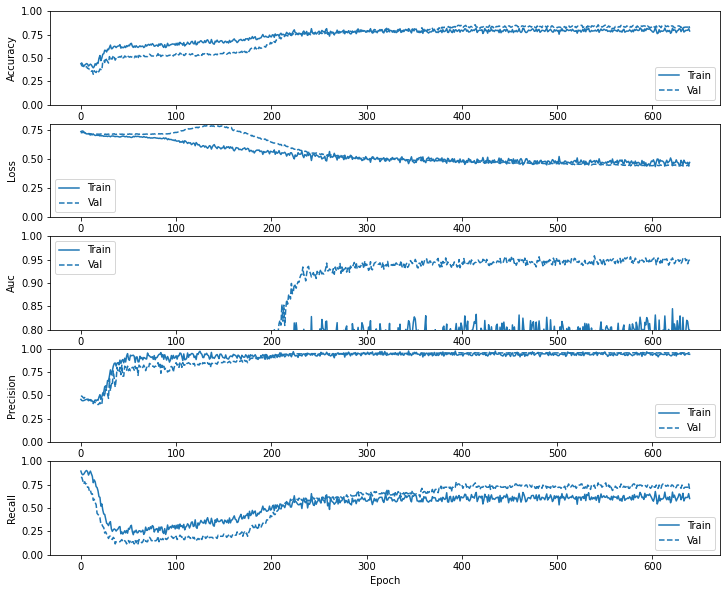

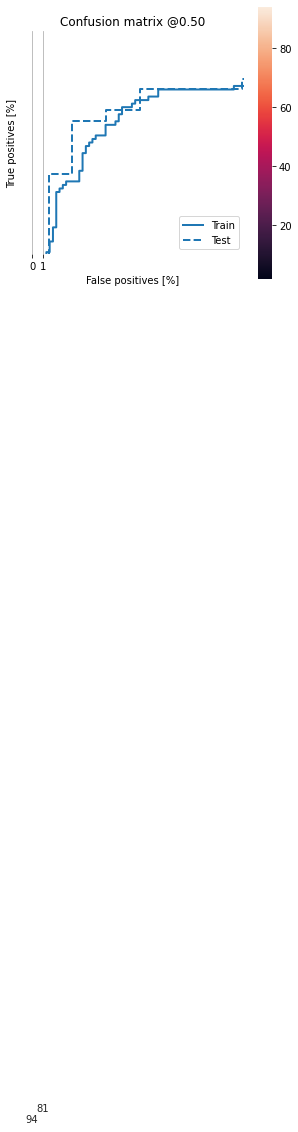

In [19]:
%%time
expId = 106
desc = str(expId) + " IQPEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_106, history_106 = runTheExperiments(expId, desc)

# Save Data For Comparisons

In [20]:
#np.savetxt(results_folder + "n" + str(num_data) + "_train_labels.csv", train_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_labels.csv", val_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_labels.csv", test_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_train_features.csv", train_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_features.csv", val_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_features.csv", test_features, delimiter=",")


# Experiments B - Classical Deep Learning

In [21]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          2, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  model.summary()

  return model
  
 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 10        
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
13/13 [==============================] - 2s 61ms/step - loss: 0.7219 - tp: 136.5000 - fp: 15.0714 - tn: 271.4286 - fn: 145.8571 - accuracy: 0.7310 - precision: 0.9041 - recall: 0.5114 - auc: 0.7381 - val_loss: 0.6798 - val_tp: 34.0000 - val_fp: 11.0000 - val_tn: 62.0000 - val_fn: 52.0000 - val_accuracy: 0.6038 - val_precision: 0.7556 - val_recall: 0.3953 - val_auc: 0.5277

13/13 [==============================] - 0s 8ms/step - loss: 0.6285 - tp: 62.1429 - fp: 11.3571 - tn: 178.4286 - fn: 117.9286 - accuracy: 0.6543 - precision: 0.8502 - recall: 0.3342 - auc: 0.6193 - val_loss: 0.5557 - val_tp: 56.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 30.0000 - val_accuracy: 0.7610 - val_precision: 0.8750 - val_recall: 0.6512 - val_auc: 0.8202
Epoch 21/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.6123 - tp: 70.5000 - fp: 9.0000 - tn: 179.2143 - fn: 111.1429 - accuracy: 0.6852 - precision: 0.9026 - recall: 0.4016 - auc: 0.6502 - val_loss: 0.5526 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 30.0000 - val_accuracy: 0.7673 - val_precision: 0.8889 - val_recall: 0.6512 - val_auc: 0.8214
Epoch 22/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.6104 - tp: 71.4286 - fp: 11.5000 - tn: 176.0714 - fn: 110.8571 - accuracy: 0.6622 - precision: 0.8699 - recall: 0.3830 - auc: 0.6580 - val_loss: 0.5500 - val_tp: 56

13/13 [==============================] - 0s 9ms/step - loss: 0.6091 - tp: 59.0714 - fp: 10.9286 - tn: 179.7857 - fn: 120.0714 - accuracy: 0.6333 - precision: 0.8598 - recall: 0.3159 - auc: 0.6379 - val_loss: 0.5134 - val_tp: 59.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 27.0000 - val_accuracy: 0.7925 - val_precision: 0.9077 - val_recall: 0.6860 - val_auc: 0.8596
Epoch 42/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5634 - tp: 71.0000 - fp: 8.7143 - tn: 188.8571 - fn: 101.2857 - accuracy: 0.7145 - precision: 0.8999 - recall: 0.4204 - auc: 0.7201 - val_loss: 0.5120 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 27.0000 - val_accuracy: 0.7987 - val_precision: 0.9219 - val_recall: 0.6860 - val_auc: 0.8587
Epoch 43/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5910 - tp: 65.7857 - fp: 10.2857 - tn: 181.5000 - fn: 112.2857 - accuracy: 0.6634 - precision: 0.8666 - recall: 0.3504 - auc: 0.6852 - val_loss: 0.5110 - val_tp: 59

13/13 [==============================] - 0s 8ms/step - loss: 0.5836 - tp: 68.2857 - fp: 8.4286 - tn: 180.7143 - fn: 112.4286 - accuracy: 0.6723 - precision: 0.8888 - recall: 0.3720 - auc: 0.6929 - val_loss: 0.4968 - val_tp: 57.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 29.0000 - val_accuracy: 0.7862 - val_precision: 0.9194 - val_recall: 0.6628 - val_auc: 0.8676
Epoch 63/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.6028 - tp: 63.4286 - fp: 13.6429 - tn: 180.8571 - fn: 111.9286 - accuracy: 0.6584 - precision: 0.7919 - recall: 0.3628 - auc: 0.6757 - val_loss: 0.4963 - val_tp: 57.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 29.0000 - val_accuracy: 0.7862 - val_precision: 0.9194 - val_recall: 0.6628 - val_auc: 0.8690
Epoch 64/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5579 - tp: 74.5000 - fp: 11.3571 - tn: 180.2857 - fn: 103.7143 - accuracy: 0.6857 - precision: 0.8761 - recall: 0.4121 - auc: 0.7283 - val_loss: 0.4953 - val_tp: 57

13/13 [==============================] - 0s 8ms/step - loss: 0.5726 - tp: 72.7857 - fp: 12.3571 - tn: 174.9286 - fn: 109.7857 - accuracy: 0.6662 - precision: 0.8706 - recall: 0.3806 - auc: 0.7171 - val_loss: 0.4787 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8773
Epoch 84/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5872 - tp: 65.1429 - fp: 10.6429 - tn: 182.3571 - fn: 111.7143 - accuracy: 0.6591 - precision: 0.8619 - recall: 0.3479 - auc: 0.6884 - val_loss: 0.4780 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8810
Epoch 85/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5342 - tp: 78.1429 - fp: 7.3571 - tn: 186.2857 - fn: 98.0714 - accuracy: 0.7250 - precision: 0.9222 - recall: 0.4546 - auc: 0.7475 - val_loss: 0.4773 - val_tp: 57.

13/13 [==============================] - 0s 8ms/step - loss: 0.5363 - tp: 67.5000 - fp: 5.4286 - tn: 189.4286 - fn: 107.5000 - accuracy: 0.6901 - precision: 0.9313 - recall: 0.3795 - auc: 0.7499 - val_loss: 0.4481 - val_tp: 60.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 26.0000 - val_accuracy: 0.8050 - val_precision: 0.9231 - val_recall: 0.6977 - val_auc: 0.9122
Epoch 105/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5187 - tp: 66.1429 - fp: 6.1429 - tn: 189.4286 - fn: 108.1429 - accuracy: 0.6998 - precision: 0.9219 - recall: 0.3771 - auc: 0.7719 - val_loss: 0.4459 - val_tp: 61.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 25.0000 - val_accuracy: 0.8113 - val_precision: 0.9242 - val_recall: 0.7093 - val_auc: 0.9103
Epoch 106/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.5369 - tp: 74.8571 - fp: 11.6429 - tn: 176.2143 - fn: 107.1429 - accuracy: 0.6758 - precision: 0.8678 - recall: 0.4182 - auc: 0.7580 - val_loss: 0.4449 - val_tp: 6

13/13 [==============================] - 0s 8ms/step - loss: 0.5248 - tp: 70.2143 - fp: 8.9286 - tn: 185.2143 - fn: 105.5000 - accuracy: 0.6852 - precision: 0.8623 - recall: 0.3935 - auc: 0.7712 - val_loss: 0.4194 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9307
Epoch 126/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.5285 - tp: 66.3571 - fp: 10.2143 - tn: 183.8571 - fn: 109.4286 - accuracy: 0.6723 - precision: 0.8554 - recall: 0.3661 - auc: 0.7713 - val_loss: 0.4180 - val_tp: 62.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 24.0000 - val_accuracy: 0.8239 - val_precision: 0.9394 - val_recall: 0.7209 - val_auc: 0.9314
Epoch 127/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5239 - tp: 70.8571 - fp: 6.1429 - tn: 180.5714 - fn: 112.2857 - accuracy: 0.6821 - precision: 0.9373 - recall: 0.3987 - auc: 0.7832 - val_loss: 0.4160 - val_tp: 6

13/13 [==============================] - 0s 7ms/step - loss: 0.4946 - tp: 69.8571 - fp: 7.0000 - tn: 180.8571 - fn: 112.1429 - accuracy: 0.6851 - precision: 0.9167 - recall: 0.3964 - auc: 0.7929 - val_loss: 0.3983 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9422
Epoch 147/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4720 - tp: 85.6429 - fp: 7.2857 - tn: 179.0000 - fn: 97.9286 - accuracy: 0.7163 - precision: 0.9283 - recall: 0.4717 - auc: 0.8224 - val_loss: 0.3976 - val_tp: 66.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 20.0000 - val_accuracy: 0.8553 - val_precision: 0.9565 - val_recall: 0.7674 - val_auc: 0.9423
Epoch 148/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5006 - tp: 71.0714 - fp: 10.1429 - tn: 181.5000 - fn: 107.1429 - accuracy: 0.6886 - precision: 0.8726 - recall: 0.4152 - auc: 0.8039 - val_loss: 0.3971 - val_tp: 65

13/13 [==============================] - 0s 9ms/step - loss: 0.4994 - tp: 69.9286 - fp: 10.2143 - tn: 181.9286 - fn: 107.7857 - accuracy: 0.6837 - precision: 0.8612 - recall: 0.3964 - auc: 0.7840 - val_loss: 0.3848 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9482
Epoch 168/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4655 - tp: 87.7857 - fp: 5.8571 - tn: 178.3571 - fn: 97.8571 - accuracy: 0.7119 - precision: 0.9442 - recall: 0.4776 - auc: 0.8301 - val_loss: 0.3837 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9483
Epoch 169/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4843 - tp: 73.9286 - fp: 6.2143 - tn: 184.7857 - fn: 104.9286 - accuracy: 0.6951 - precision: 0.9247 - recall: 0.4104 - auc: 0.8039 - val_loss: 0.3836 - val_tp: 65

13/13 [==============================] - 0s 6ms/step - loss: 0.4686 - tp: 72.4286 - fp: 4.7143 - tn: 187.5000 - fn: 105.2143 - accuracy: 0.7052 - precision: 0.9441 - recall: 0.4022 - auc: 0.8186 - val_loss: 0.3790 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9526
Epoch 189/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4916 - tp: 75.8571 - fp: 10.5000 - tn: 180.1429 - fn: 103.3571 - accuracy: 0.6953 - precision: 0.8758 - recall: 0.4334 - auc: 0.7996 - val_loss: 0.3786 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9532
Epoch 190/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4781 - tp: 63.5000 - fp: 7.5000 - tn: 189.6429 - fn: 109.2143 - accuracy: 0.6857 - precision: 0.8891 - recall: 0.3690 - auc: 0.8131 - val_loss: 0.3780 - val_tp: 6

13/13 [==============================] - 0s 8ms/step - loss: 0.4750 - tp: 74.6429 - fp: 6.5714 - tn: 180.7857 - fn: 107.8571 - accuracy: 0.6928 - precision: 0.9176 - recall: 0.4169 - auc: 0.8115 - val_loss: 0.3676 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9548
Epoch 210/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4876 - tp: 70.2857 - fp: 7.0000 - tn: 185.7143 - fn: 106.8571 - accuracy: 0.6914 - precision: 0.9089 - recall: 0.3837 - auc: 0.7934 - val_loss: 0.3673 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9541
Epoch 211/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5002 - tp: 58.2143 - fp: 4.2143 - tn: 186.9286 - fn: 120.5000 - accuracy: 0.6588 - precision: 0.9385 - recall: 0.3151 - auc: 0.7805 - val_loss: 0.3664 - val_tp: 68

13/13 [==============================] - 0s 8ms/step - loss: 0.4552 - tp: 82.9286 - fp: 8.0000 - tn: 181.7857 - fn: 97.1429 - accuracy: 0.7134 - precision: 0.9028 - recall: 0.4610 - auc: 0.8272 - val_loss: 0.3600 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9568
Epoch 231/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4497 - tp: 81.0000 - fp: 6.5000 - tn: 176.8571 - fn: 105.5000 - accuracy: 0.6943 - precision: 0.9288 - recall: 0.4522 - auc: 0.8279 - val_loss: 0.3591 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9568
Epoch 232/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4763 - tp: 70.2143 - fp: 7.2143 - tn: 190.0000 - fn: 102.4286 - accuracy: 0.7101 - precision: 0.9198 - recall: 0.4144 - auc: 0.8093 - val_loss: 0.3577 - val_tp: 69.

13/13 [==============================] - 0s 8ms/step - loss: 0.4554 - tp: 82.6429 - fp: 5.4286 - tn: 183.5714 - fn: 98.2143 - accuracy: 0.7192 - precision: 0.9416 - recall: 0.4634 - auc: 0.8269 - val_loss: 0.3507 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9530
Epoch 252/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4639 - tp: 73.4286 - fp: 8.0714 - tn: 188.2857 - fn: 100.0714 - accuracy: 0.7144 - precision: 0.8893 - recall: 0.4311 - auc: 0.8182 - val_loss: 0.3504 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9529
Epoch 253/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4620 - tp: 72.5714 - fp: 5.9286 - tn: 187.8571 - fn: 103.5000 - accuracy: 0.7111 - precision: 0.9255 - recall: 0.4182 - auc: 0.8165 - val_loss: 0.3504 - val_tp: 73.

13/13 [==============================] - 0s 8ms/step - loss: 0.4771 - tp: 82.6429 - fp: 7.4286 - tn: 182.1429 - fn: 97.6429 - accuracy: 0.7091 - precision: 0.9176 - recall: 0.4443 - auc: 0.8156 - val_loss: 0.3440 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9529
Epoch 273/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4725 - tp: 66.2857 - fp: 6.8571 - tn: 189.6429 - fn: 107.0714 - accuracy: 0.6931 - precision: 0.9324 - recall: 0.3728 - auc: 0.8091 - val_loss: 0.3440 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9534
Epoch 274/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4407 - tp: 82.9286 - fp: 6.0000 - tn: 192.7143 - fn: 88.2143 - accuracy: 0.7600 - precision: 0.9203 - recall: 0.4972 - auc: 0.8366 - val_loss: 0.3439 - val_tp: 74.0

13/13 [==============================] - 0s 7ms/step - loss: 0.4734 - tp: 72.0714 - fp: 7.3571 - tn: 185.3571 - fn: 105.0714 - accuracy: 0.6989 - precision: 0.8953 - recall: 0.4087 - auc: 0.7985 - val_loss: 0.3422 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9535
Epoch 294/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4813 - tp: 66.0714 - fp: 6.6429 - tn: 186.9286 - fn: 110.2143 - accuracy: 0.6750 - precision: 0.9248 - recall: 0.3662 - auc: 0.7944 - val_loss: 0.3424 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9536
Epoch 295/10000
13/13 [==============================] - 0s 6ms/step - loss: 0.4533 - tp: 82.2857 - fp: 6.5714 - tn: 182.5714 - fn: 98.4286 - accuracy: 0.7241 - precision: 0.9298 - recall: 0.4674 - auc: 0.8258 - val_loss: 0.3421 - val_tp: 74.

13/13 [==============================] - 0s 9ms/step - loss: 0.4348 - tp: 77.8571 - fp: 5.2857 - tn: 191.4286 - fn: 95.2857 - accuracy: 0.7360 - precision: 0.9454 - recall: 0.4551 - auc: 0.8469 - val_loss: 0.3363 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9560
Epoch 315/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4428 - tp: 76.8571 - fp: 5.9286 - tn: 187.5000 - fn: 99.5714 - accuracy: 0.7265 - precision: 0.9419 - recall: 0.4517 - auc: 0.8384 - val_loss: 0.3358 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9564
Epoch 316/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4632 - tp: 81.9286 - fp: 5.2857 - tn: 185.1429 - fn: 97.5000 - accuracy: 0.7108 - precision: 0.9416 - recall: 0.4441 - auc: 0.8231 - val_loss: 0.3357 - val_tp: 74.00

13/13 [==============================] - 0s 7ms/step - loss: 0.4607 - tp: 85.1429 - fp: 9.7143 - tn: 177.6429 - fn: 97.3571 - accuracy: 0.7120 - precision: 0.8818 - recall: 0.4705 - auc: 0.8114 - val_loss: 0.3296 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9556
Epoch 336/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4805 - tp: 79.0714 - fp: 6.2143 - tn: 182.6429 - fn: 101.9286 - accuracy: 0.7102 - precision: 0.9338 - recall: 0.4484 - auc: 0.8050 - val_loss: 0.3302 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9552
Epoch 337/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4600 - tp: 76.8571 - fp: 6.1429 - tn: 193.7857 - fn: 93.0714 - accuracy: 0.7271 - precision: 0.9071 - recall: 0.4415 - auc: 0.8155 - val_loss: 0.3296 - val_tp: 74.0

13/13 [==============================] - 0s 8ms/step - loss: 0.4648 - tp: 66.4286 - fp: 7.6429 - tn: 192.4286 - fn: 103.3571 - accuracy: 0.7106 - precision: 0.8870 - recall: 0.3799 - auc: 0.8083 - val_loss: 0.3313 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9553
Epoch 357/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4500 - tp: 74.7857 - fp: 4.6429 - tn: 191.2143 - fn: 99.2143 - accuracy: 0.7193 - precision: 0.9545 - recall: 0.4220 - auc: 0.8296 - val_loss: 0.3294 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9545
Epoch 358/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4764 - tp: 80.7143 - fp: 3.0714 - tn: 188.0000 - fn: 98.0714 - accuracy: 0.7198 - precision: 0.9528 - recall: 0.4403 - auc: 0.8034 - val_loss: 0.3284 - val_tp: 75.0

13/13 [==============================] - 0s 7ms/step - loss: 0.4418 - tp: 78.9286 - fp: 5.7857 - tn: 194.1429 - fn: 91.0000 - accuracy: 0.7465 - precision: 0.9343 - recall: 0.4646 - auc: 0.8287 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Epoch 378/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4340 - tp: 83.1429 - fp: 8.7143 - tn: 185.9286 - fn: 92.0714 - accuracy: 0.7351 - precision: 0.9077 - recall: 0.4867 - auc: 0.8430 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9542
Epoch 379/10000
13/13 [==============================] - 0s 7ms/step - loss: 0.4420 - tp: 77.7857 - fp: 4.7143 - tn: 187.4286 - fn: 99.9286 - accuracy: 0.7183 - precision: 0.9529 - recall: 0.4412 - auc: 0.8356 - val_loss: 0.3257 - val_tp: 75.00

13/13 [==============================] - 0s 8ms/step - loss: 0.4954 - tp: 74.0000 - fp: 6.5714 - tn: 182.1429 - fn: 107.1429 - accuracy: 0.6870 - precision: 0.9211 - recall: 0.3954 - auc: 0.7932 - val_loss: 0.3263 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9540
Epoch 399/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4880 - tp: 83.1429 - fp: 5.3571 - tn: 182.6429 - fn: 98.7143 - accuracy: 0.7101 - precision: 0.9335 - recall: 0.4624 - auc: 0.7927 - val_loss: 0.3267 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Epoch 400/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4478 - tp: 82.6429 - fp: 5.0714 - tn: 185.1429 - fn: 97.0000 - accuracy: 0.7124 - precision: 0.9433 - recall: 0.4515 - auc: 0.8407 - val_loss: 0.3253 - val_tp: 75.0

13/13 [==============================] - 0s 8ms/step - loss: 0.4512 - tp: 79.8571 - fp: 5.2857 - tn: 187.7143 - fn: 97.0000 - accuracy: 0.7160 - precision: 0.9286 - recall: 0.4512 - auc: 0.8264 - val_loss: 0.3215 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Restoring model weights from the end of the best epoch.
Epoch 00419: early stopping
loss :  0.28389766812324524
tp :  95.0
fp :  4.0
tn :  92.0
fn :  8.0
accuracy :  0.9396985173225403
precision :  0.9595959782600403
recall :  0.9223300814628601
auc :  0.978762149810791

Legitimate Domain Name Detected (True Negatives):  92
Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives):  4
Botnet DGA Missed (False Negatives):  8
Botnet DGA Detected (True Positives):  95
Total Botnet DGAs:  103
CPU times: user 1min 5s, sys: 4.06 s, total: 1min 9s
Wall time: 56.9 s


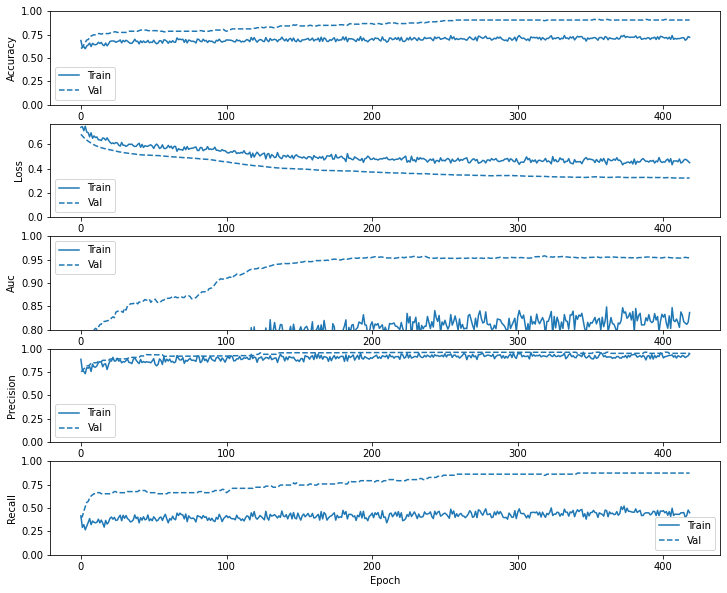

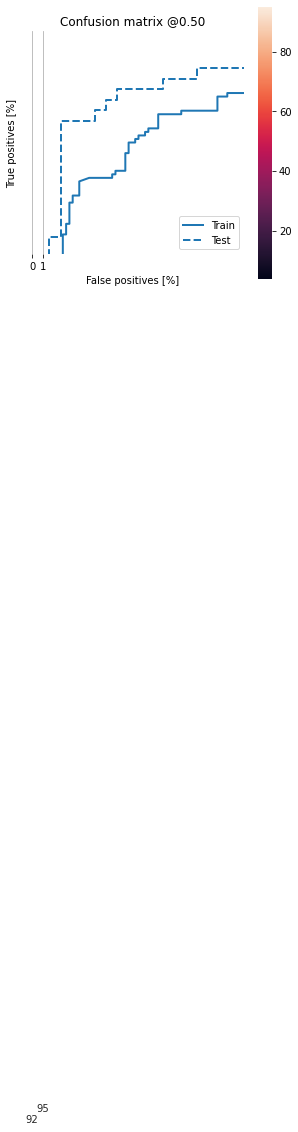

In [22]:
%%time
expId = 201
desc = str(expId) + " Classical Deep Learning" 

model_201, history_201 = runTheExperiments(expId, desc)


In [23]:
f.write("19_BotnetDga_Benchmarks - CPU n100 1layer - Device Noise Model ibmq_quito - qiskit.aer - seed 123")
f.flush()